# Análisis Exploratorio - Indice delictivo en Hermosillo

Este notebook realiza un análisis exploratorio completo del dataset unificado incluyendo:
- Análisis de datos faltantes
- Detección de anomalías con múltiples técnicas
- Visualización de relaciones entre variables
- Análisis de correlación

## 1. Importar Librerías y Cargar Datos

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
import os
import missingno as msno # Librería para visualización de datos faltantes

# Suprimir todos los warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Suprimir warnings específicos de librerías
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('sklearn').setLevel(logging.ERROR)

# ===== CONFIGURACIÓN DE ESTILOS PROFESIONALES =====
# Paletas de colores
sns.set_palette("husl")
sns.set_theme(style="whitegrid")

# Tema personalizado
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.1)

# Configuración de figuras
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.7

# Cargar datos
project_root = Path.cwd().parent
data_path = project_root / 'data' / 'processed' / 'unificado' / 'poligonos_unificados_completo.csv'

print(f"Cargando datos desde: {data_path}")
df = pd.read_csv(data_path)

print(f"\n✓ Dataset cargado exitosamente")
print(f"  Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

Cargando datos desde: c:\Users\fanny\OneDrive\Documentos\_MCD\ing_caracteristicas\proyectos\delitos_hmo\indice-delictivo-hermosillo\data\processed\unificado\poligonos_unificados_completo.csv

✓ Dataset cargado exitosamente
  Dimensiones: 700 filas × 30 columnas

Primeras filas:


,cve_ent,cve_mun,cve_loc,nom_loc,CVE_COL,COLONIA,CP,otros_cp,total_incidentes,incidentes_alta,...,viviendas_totales,escolaridad_años_prom,pctj_menores18,pctj_hombres,pctj_mujeres,tasa_incidentes_per_1k,tasa_alta_severidad_per_1k,score_severidad,area_km2,densidad_poblacional
0,26,30,1,Hermosillo,2603000016735,ALTA FIRENZE NORTE RESIDENCIAL,83104.0,NaN,1,1,...,68.0,14.9,28.6%,49.4%,50.6%,12.987013,12.987013,3.000000,0.037555,2050.340413
1,26,30,1,Hermosillo,2603000011785,JORGE VALDEZ MUÃOZ,83104.0,NaN,3066,1404,...,366.0,9.4,35.7%,49.9%,50.1%,2836.262720,1298.797410,2.199609,0.108585,9955.346547
2,26,30,1,Hermosillo,2603000016335,VILLA VERDE CERRADA SAN VICENTE,83118.0,NaN,0,0,...,261.0,9.5,40.4%,52.4%,47.6%,0.000000,0.000000,0.000000,0.060584,11801.826946
3,26,30,1,Hermosillo,2603000011480,VILLA VENTURA,83159.0,NaN,0,0,...,86.0,14.2,21.7%,46.5%,53.5%,0.000000,0.000000,0.000000,0.017695,6781.506720
4,26,30,1,Hermosillo,2603000011663,NUEVO HERMOSILLO,83296.0,NaN,43761,15415,...,4102.0,10.7,29.4%,49.1%,50.9%,3465.119962,1220.603373,2.022691,1.266794,9969.263119


### Información General del Dataset

In [33]:
df['pctj_menores18'].dtypes

dtype('O')

In [34]:
#Definición de tipos de datos para cada columna
col_categoricas = ['CVE_COL', 'COLONIA','CP']
df[col_categoricas] = df[col_categoricas].astype('category')

col_numericas = ['pctj_menores18', 'pctj_hombres', 'pctj_mujeres']
for columna in col_numericas:
    df[columna] = df[columna].str[:-1]
df[col_numericas] = df[col_numericas].astype('float')

#Eliminación de columnas redundantes/irrelevantes
columnas_a_eliminar = ['cve_ent',
                       'cve_mun',
                       'otros_cp', 
                       'cve_loc',
                       'nom_loc'
                       ]
df = df.drop(columns=columnas_a_eliminar, axis = 1)

In [35]:
# Información general
print("="*70)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*70)
print(f"\nTipo de datos:\n")
print(df.dtypes)
print(f"\nEstadísticas descriptivas:\n")
df.describe().T

INFORMACIÓN GENERAL DEL DATASET

Tipo de datos:

CVE_COL                       category
COLONIA                       category
CP                            category
total_incidentes                 int64
incidentes_alta                  int64
incidentes_media                 int64
incidentes_baja                  int64
categorias_dict                 object
partes_dia_dict                 object
incidentes_fin_semana            int64
incidentes_quincena              int64
dias_semana_dict                object
fecha_inicio                    object
fecha_fin                       object
poblacion_total                float64
viviendas_totales              float64
escolaridad_años_prom          float64
pctj_menores18                 float64
pctj_hombres                   float64
pctj_mujeres                   float64
tasa_incidentes_per_1k         float64
tasa_alta_severidad_per_1k     float64
score_severidad                float64
area_km2                       float64
densidad_poblac

,count,mean,std,min,25%,50%,75%,max
total_incidentes,700.0,3109.645714,8735.781961,0.000000,0.750000,430.500000,2675.000000,1.579690e+05
incidentes_alta,700.0,1087.212857,2872.708030,0.000000,0.000000,134.000000,865.000000,4.626100e+04
incidentes_media,700.0,1256.200000,3780.424365,0.000000,0.000000,163.500000,1109.750000,7.078400e+04
incidentes_baja,700.0,766.232857,2183.428513,0.000000,0.000000,98.000000,691.250000,4.092400e+04
incidentes_fin_semana,700.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
incidentes_quincena,700.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
poblacion_total,659.0,1290.000000,2095.321602,0.000000,260.500000,618.000000,1390.500000,2.039800e+04
viviendas_totales,659.0,445.330804,715.978916,0.000000,92.500000,216.000000,491.000000,7.175000e+03
escolaridad_años_prom,642.0,12.433022,2.250755,1.700000,10.500000,12.700000,14.500000,1.870000e+01
pctj_menores18,642.0,28.658879,9.560639,4.700000,21.725000,29.450000,35.075000,9.970000e+01


## 2. Análisis de Datos Faltantes

In [36]:
# Análisis de datos faltantes
print("="*70)
print("ANÁLISIS DE DATOS FALTANTES")
print("="*70)

# Contar valores nulos
missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Nulos': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df) * 100).round(2),
    'Tipo_Datos': df.dtypes
}).sort_values('Valores_Nulos', ascending=False)

missing_data = missing_data[missing_data['Valores_Nulos'] > 0]

if len(missing_data) == 0:
    print("\n✓ No hay datos faltantes en el dataset")
else:
    print(f"\n⚠️  Se encontraron {len(missing_data)} columnas con datos faltantes:\n")
    print(missing_data.to_string())

print(f"\nTotal de valores nulos: {df.isnull().sum().sum():,}")
print(f"Porcentaje total de valores nulos: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

ANÁLISIS DE DATOS FALTANTES

⚠️  Se encontraron 14 columnas con datos faltantes:

                                               Columna  Valores_Nulos  Porcentaje Tipo_Datos
categorias_dict                        categorias_dict            175       25.00     object
partes_dia_dict                        partes_dia_dict            175       25.00     object
fecha_fin                                    fecha_fin            175       25.00     object
dias_semana_dict                      dias_semana_dict            175       25.00     object
fecha_inicio                              fecha_inicio            175       25.00     object
escolaridad_años_prom            escolaridad_años_prom             58        8.29    float64
pctj_menores18                          pctj_menores18             58        8.29    float64
pctj_mujeres                              pctj_mujeres             58        8.29    float64
pctj_hombres                              pctj_hombres             58        8.29

### Visualización de Datos Faltantes

<Axes: >

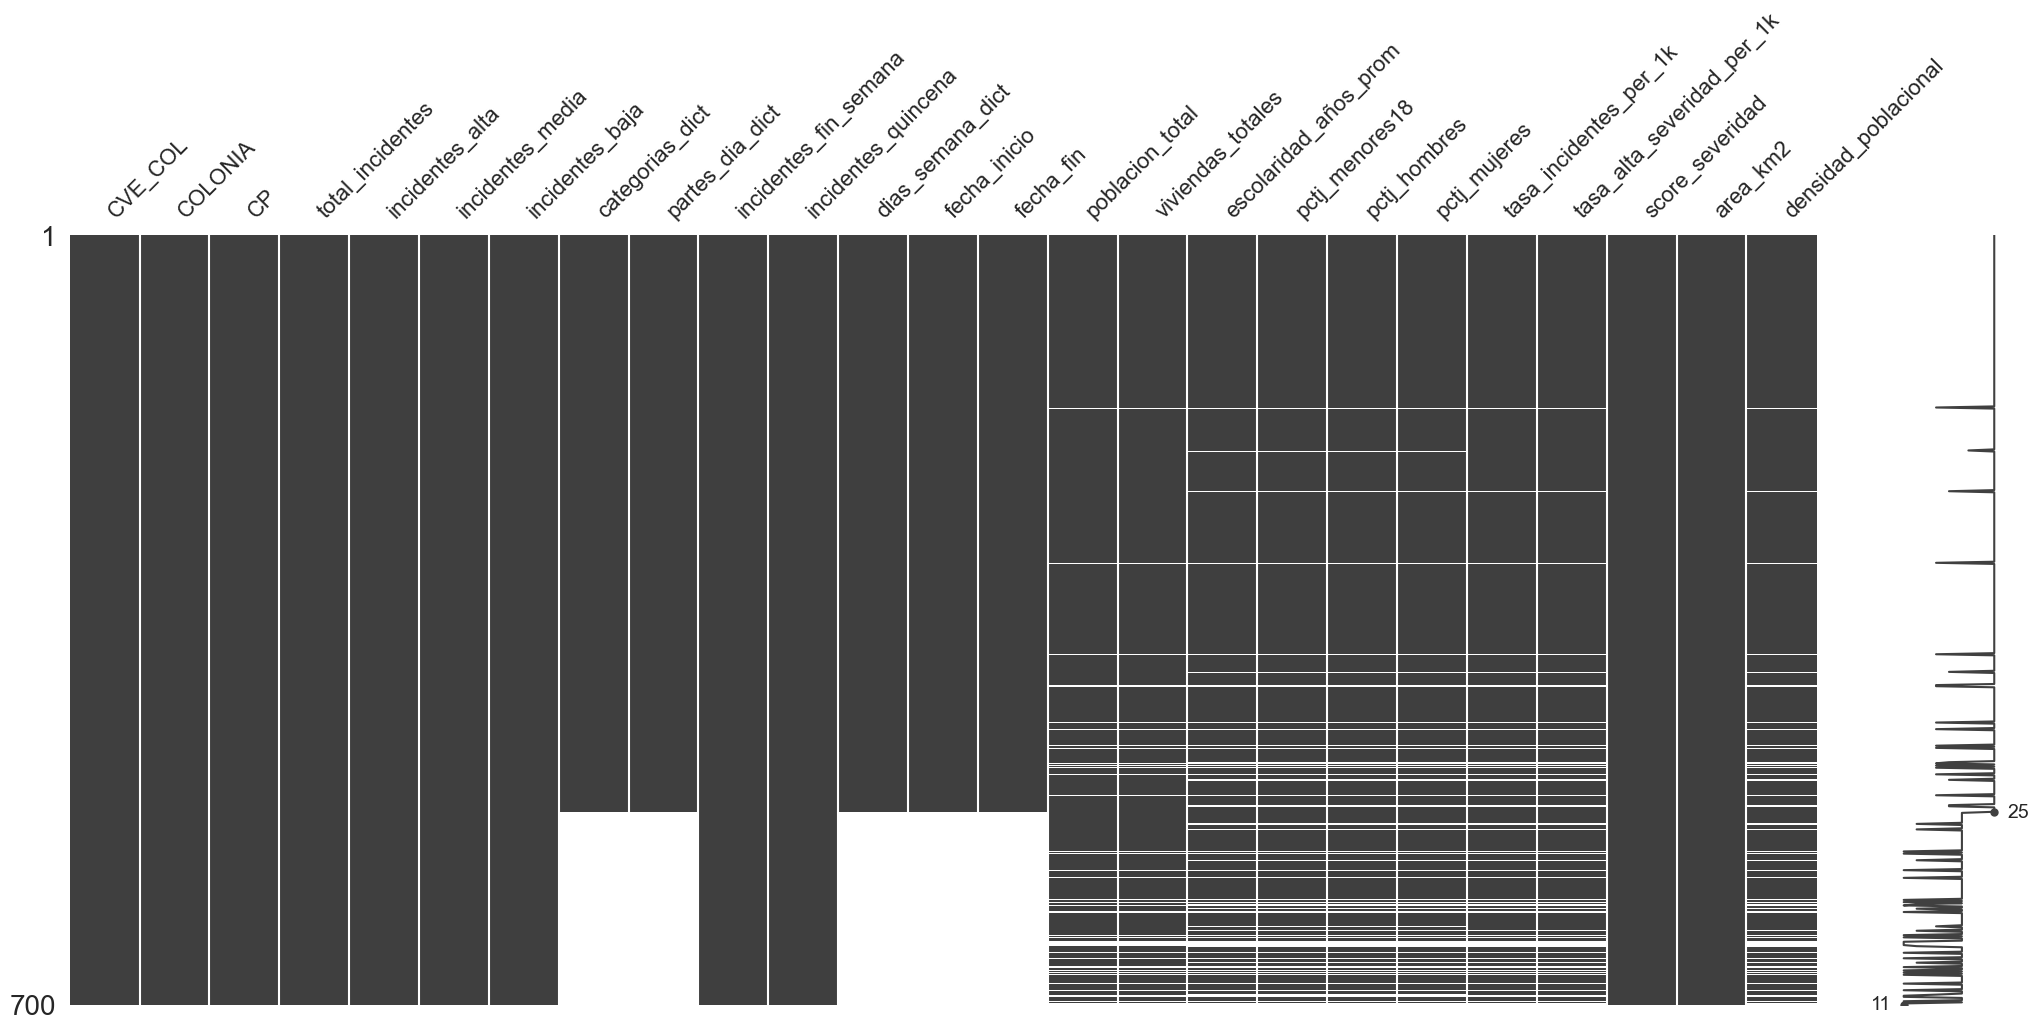

In [44]:
#Matriz de datos faltantes ordenada por fecha_inicio de los reportes
sorted = df.sort_values('fecha_inicio')
msno.matrix(sorted)

In [ ]:
#Cruce de colonias sin incidentes y su población
df[df['fecha_inicio'].isnull()][['COLONIA', 'poblacion_total', 'total_incidentes']]

,COLONIA,poblacion_total,total_incidentes
2,VILLA VERDE CERRADA SAN VICENTE,715.0,0
3,VILLA VENTURA,120.0,0
7,COLINA BLANCA,296.0,0
11,EL 33,179.0,0
15,LA JOLLA SECCION VILLA DE LOS DIAMANTES,23.0,0
...,...,...,...
674,LOMAS DEL MARQUEZ,656.0,0
687,LAS VEREDAS,NaN,0
688,AMPLIACIN 4 DE MARZO,781.0,0
690,PRIVADA LOS SAUCES,NaN,0


Podemos observar que los valores faltantes de las siguientes columnas coinciden: 
* **categorias_dict**
* **partes_dia_dict**
* **dias_semana_dict**
* **fecha_inicio**
* **fecha_fin**
 
 
 es posible que las observaciones/colonias que tienen valores faltantes en estas columnas no se encuentren en el registro de llamadas recibidas del 911 o que haya habido un error a la hora de unir las bases de datos de demografía y reportes de llamadas recibidas.

<Axes: >

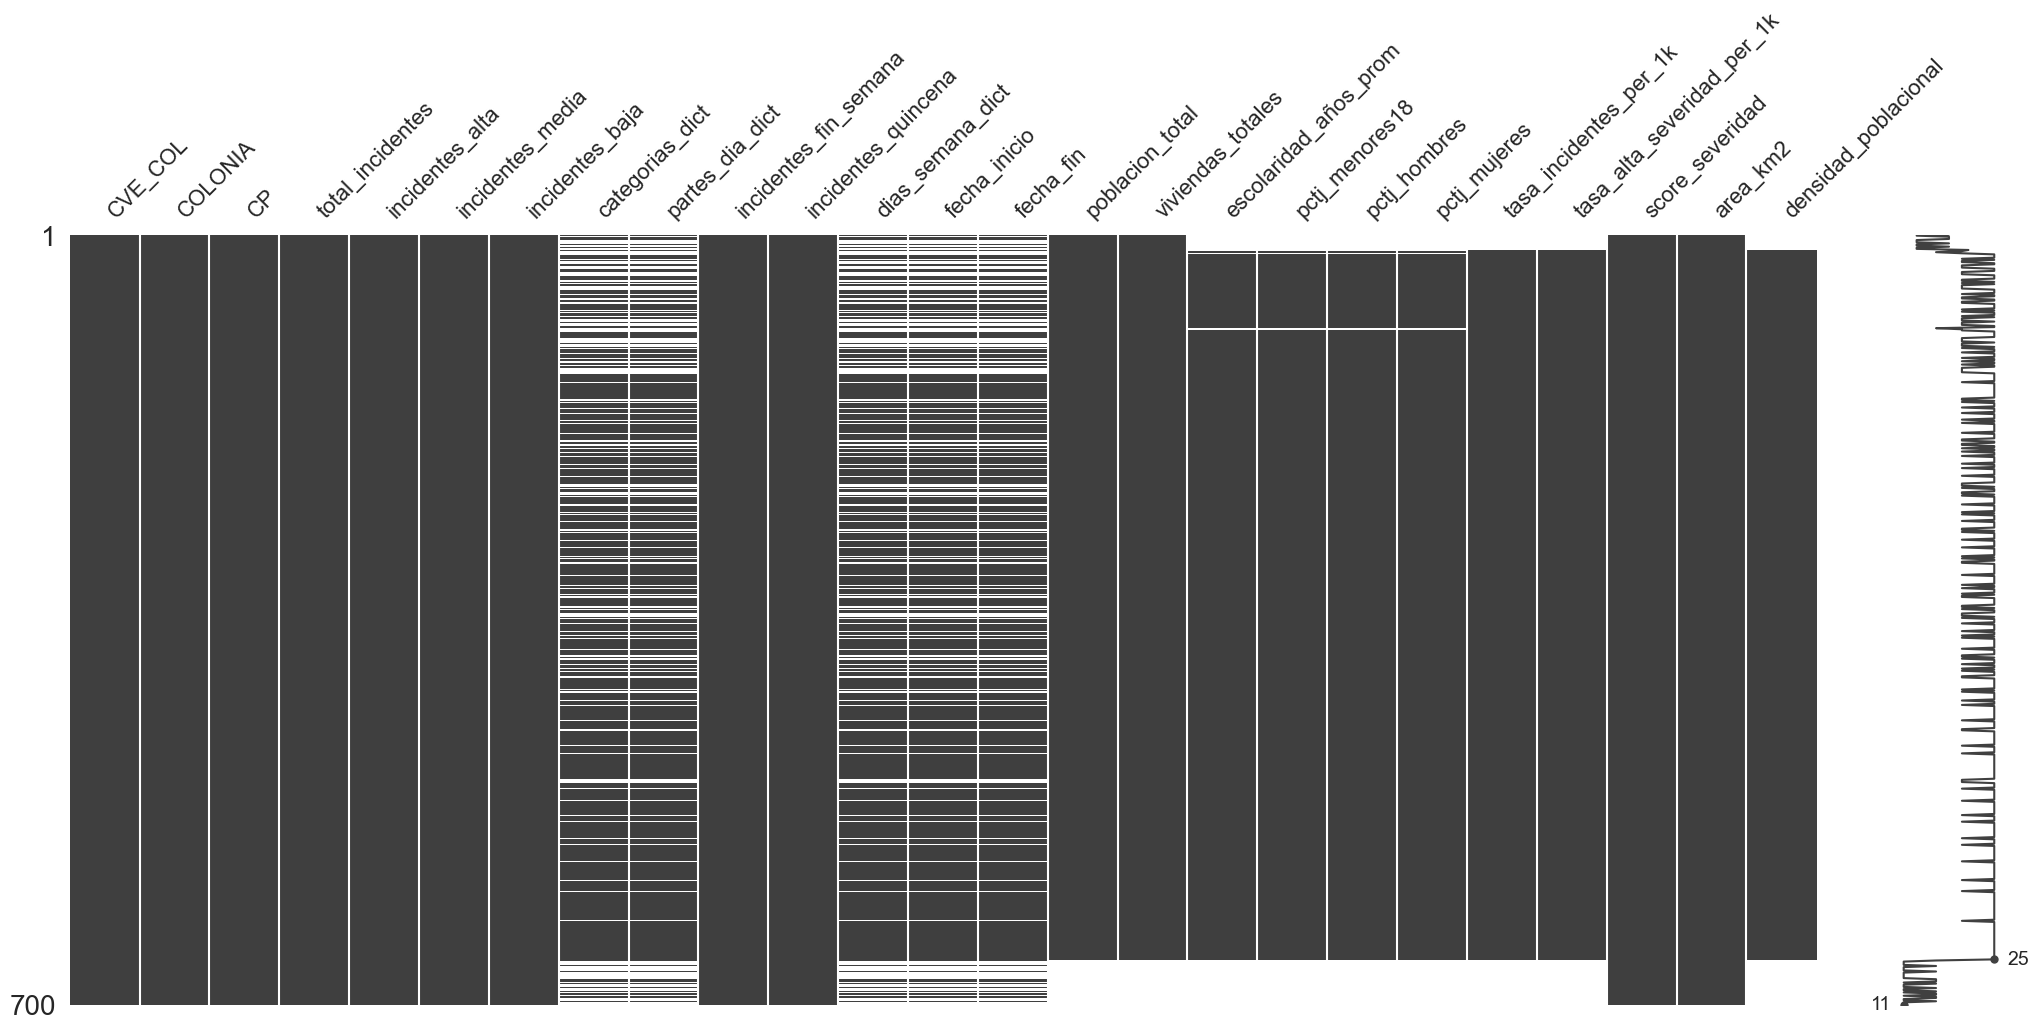

In [45]:
#Matriz de datos faltantes ordenada por poblacion_total
sorted = df.sort_values('poblacion_total')
msno.matrix(sorted)

In [51]:
#Cruce de colonias sin población y su número de incidentes
df[df['poblacion_total'].isnull()][['COLONIA', 'poblacion_total', 'total_incidentes']]

,COLONIA,poblacion_total,total_incidentes
121,CAMPESTRE RESIDENCIAL,NaN,5
165,CARDENO ENTORNO,NaN,0
182,RESIDENCIAL FLAMINGOS,NaN,0
218,CERRO 36,NaN,0
248,CONDOMINIOS LOS PORTALES RESIDENCIAL,NaN,0
292,LOS FRAILES,NaN,13
321,14 DE MARZO,NaN,0
331,RETORNO JALAPA,NaN,0
343,PARAISO PITIC,NaN,0
363,CANARIOS,NaN,0


Nuevamente, tenemos múltiples columnas en las cuales coincide la ausencia de datos: 
* **poblacion_total**
* **viviendas_totales**

Así como las siguientes columnas también coinciden:
* **escolaridad_años_prom**
* **pctj_menores18**
* **pctj_hombres**
* **pctj_mujeres**
* **tasa_inicidentes_per_1k**
* **tasa_alta_severidad_per_1k**
* **densidad_poblacional**


Es posible que no existan datos demográficos para las colonias que tienen valores faltantes en estas columnas, o nuevamente, que haya habido un error al unir las bases de datos por la variación de los nombres de las colonias (Privada / Residencial / RDCIAL / Club).

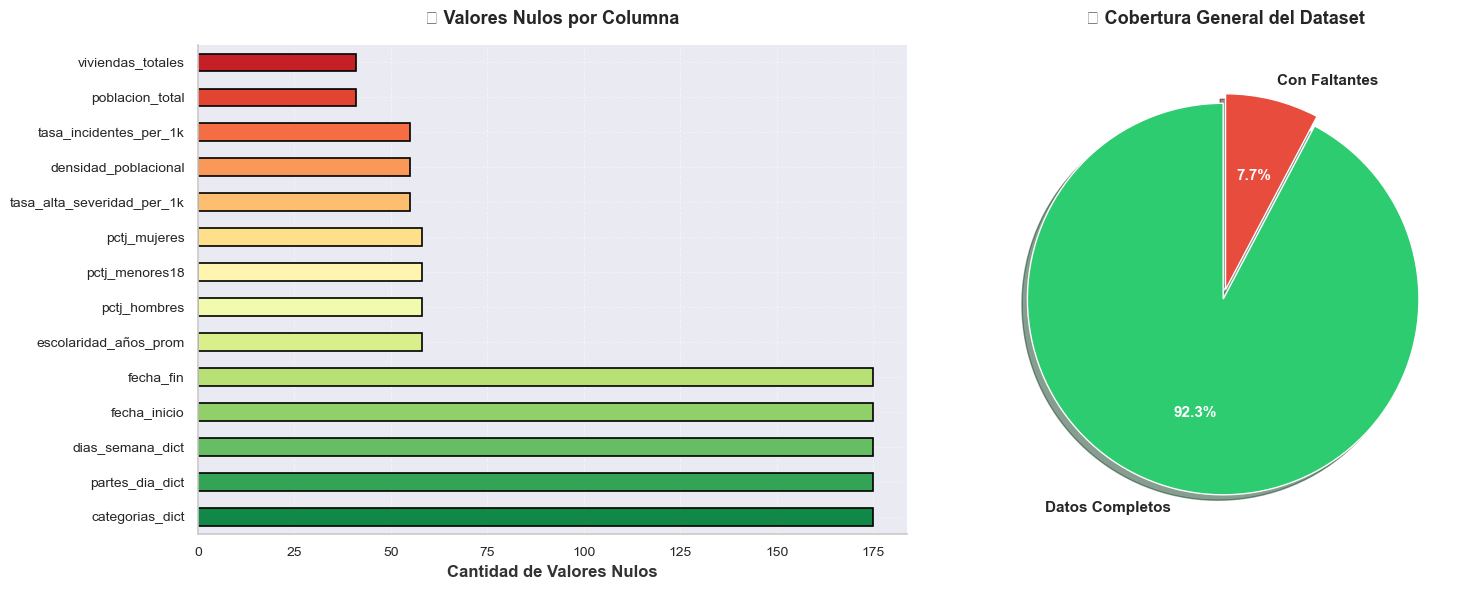

In [52]:
# Visualizar datos faltantes con estilo mejorado
if df.isnull().sum().sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras - Valores nulos por columna
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    # Paleta gradual
    colors = sns.color_palette("RdYlGn_r", len(missing_counts))
    missing_counts.plot(kind='barh', ax=axes[0], color=colors, edgecolor='black', linewidth=1.2)
    axes[0].set_xlabel('Cantidad de Valores Nulos', fontweight='bold', fontsize=12)
    axes[0].set_title('📊 Valores Nulos por Columna', fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(axis='x', alpha=0.4, linestyle='--')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    
    # Gráfico circular - Porcentaje de cobertura
    coverage = (1 - df.isnull().sum() / len(df)) * 100
    total_coverage = coverage.sum() / len(coverage)
    total_missing = 100 - total_coverage
    
    colors_pie = ['#2ecc71', '#e74c3c']
    wedges, texts, autotexts = axes[1].pie([total_coverage, total_missing], 
                labels=['Datos Completos', 'Con Faltantes'], 
                autopct='%1.1f%%',
                colors=colors_pie,
                startangle=90,
                explode=(0.05, 0),
                shadow=True,
                textprops={'fontsize': 11, 'weight': 'bold'})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
    
    axes[1].set_title('📈 Cobertura General del Dataset', fontsize=13, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
else:
    print("✓ No hay datos faltantes para visualizar")

## 3. Detección de Anomalías - Métodos Estadísticos (Z-Score e IQR)

In [54]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR")
print("="*70)

# Z-Score
# Z-Score
print("\n[1] Z-SCORE METHOD:")
print("-" * 70)

# 1. Calcula los z-scores (esto sigue siendo un array de NumPy)
z_scores = np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean())))

# 2. Suma los outliers por columna (axis=0)
outlier_counts_array = (z_scores > 3).sum(axis=0)

# 3. ¡AQUÍ ESTÁ LA MAGIA!
#    Convierte el array de NumPy en una Serie de Pandas,
#    usando las columnas de tu DataFrame numérico como índice.
outliers_zscore = pd.Series(outlier_counts_array, index=df_numeric.columns)

print(f"\nOultiers detectados con |z-score| > 3:")

# 4. Ahora outliers_zscore SÍ es una Serie de Pandas
#    y el resto de tu código funcionará perfecto.
outlier_cols = outliers_zscore[outliers_zscore > 0].sort_values(ascending=False)

if len(outlier_cols) > 0:
    for col, count in outlier_cols.items():
        pct = (count / len(df)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con z-score > 3")

# Esto también fallaba, pero ahora funcionará.
# .sum() en una Serie de Pandas suma los valores.
print(f"\nTotal de outliers detectados (Z-Score): {outliers_zscore.sum():,}")

DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR

[1] Z-SCORE METHOD:
----------------------------------------------------------------------

Oultiers detectados con |z-score| > 3:
  • poblacion_total: 15 (2.14%)
  • viviendas_totales: 15 (2.14%)
  • incidentes_alta: 14 (2.00%)
  • total_incidentes: 11 (1.57%)
  • incidentes_baja: 11 (1.57%)
  • area_km2: 11 (1.57%)
  • incidentes_media: 10 (1.43%)
  • densidad_poblacional: 7 (1.00%)
  • pctj_mujeres: 6 (0.86%)
  • pctj_hombres: 6 (0.86%)
  • pctj_menores18: 5 (0.71%)
  • escolaridad_años_prom: 3 (0.43%)
  • tasa_alta_severidad_per_1k: 1 (0.14%)
  • tasa_incidentes_per_1k: 1 (0.14%)

Total de outliers detectados (Z-Score): 116


In [55]:
# IQR Method
print("\n[2] INTERQUARTILE RANGE (IQR) METHOD:")
print("-" * 70)

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()

print(f"\nOultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:")
outlier_cols_iqr = outliers_iqr[outliers_iqr > 0].sort_values(ascending=False)

if len(outlier_cols_iqr) > 0:
    for col, count in outlier_cols_iqr.items():
        pct = (count / len(df)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con método IQR")

print(f"\nTotal de outliers detectados (IQR): {outliers_iqr.sum():,}")


[2] INTERQUARTILE RANGE (IQR) METHOD:
----------------------------------------------------------------------

Oultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:
  • incidentes_alta: 95 (13.57%)
  • total_incidentes: 86 (12.29%)
  • incidentes_baja: 86 (12.29%)
  • incidentes_media: 84 (12.00%)
  • area_km2: 75 (10.71%)
  • poblacion_total: 69 (9.86%)
  • viviendas_totales: 60 (8.57%)
  • pctj_mujeres: 50 (7.14%)
  • pctj_hombres: 50 (7.14%)
  • tasa_incidentes_per_1k: 40 (5.71%)
  • tasa_alta_severidad_per_1k: 39 (5.57%)
  • densidad_poblacional: 9 (1.29%)
  • pctj_menores18: 6 (0.86%)
  • escolaridad_años_prom: 2 (0.29%)

Total de outliers detectados (IQR): 751


### Visualización de Outliers - Métodos Estadísticos

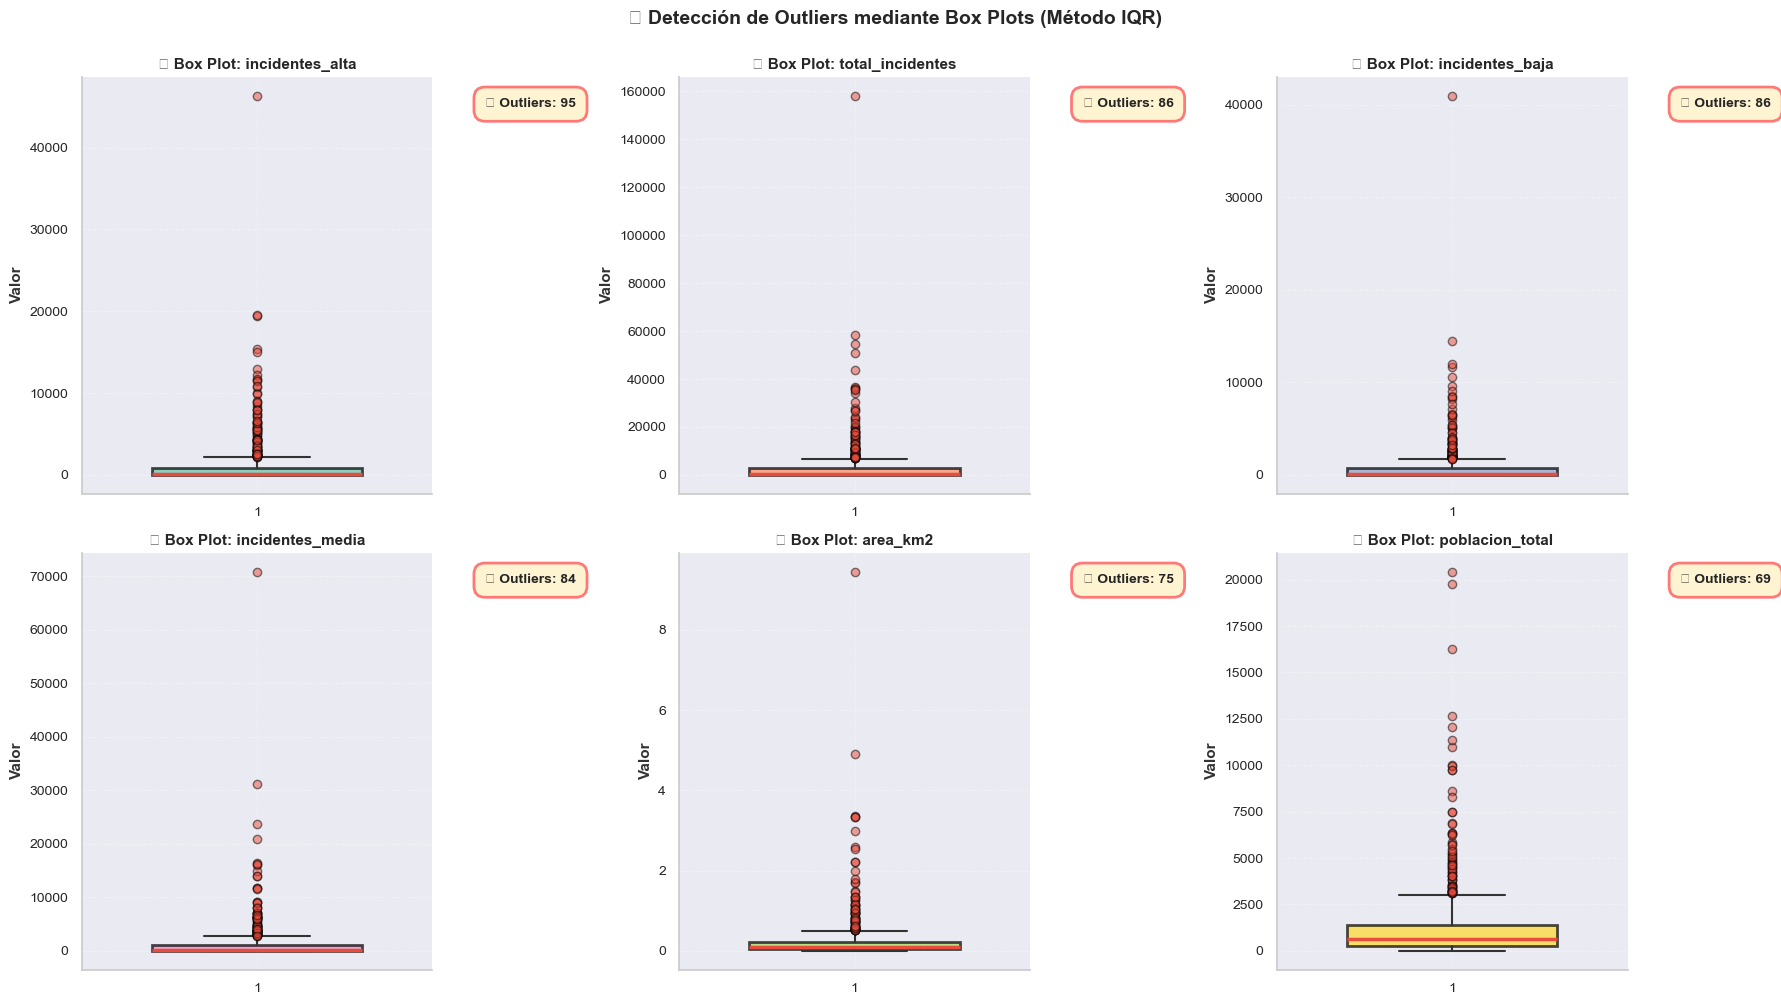


✓ Visualización: Box plots de las columnas con más outliers detectados


In [56]:
# Visualizar outliers con Box Plots - Estilo mejorado
top_cols = outlier_cols_iqr.head(6).index.tolist() if len(outlier_cols_iqr) > 0 else numeric_cols[:6]

if len(top_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    # Paleta de colores degradada
    colors_box = sns.color_palette("Set2", len(top_cols))
    
    for idx, col in enumerate(top_cols):
        # Box plot con seaborn
        data_to_plot = df_numeric[col].dropna()
        bp = axes[idx].boxplot([data_to_plot], patch_artist=True, widths=0.6,
                               boxprops=dict(facecolor=colors_box[idx], alpha=0.7, linewidth=2),
                               whiskerprops=dict(linewidth=1.5, color='#333333'),
                               capprops=dict(linewidth=1.5, color='#333333'),
                               medianprops=dict(linewidth=2.5, color='#e74c3c'),
                               flierprops=dict(marker='o', markerfacecolor='#e74c3c', 
                                            markersize=6, alpha=0.5))
        
        axes[idx].set_title(f'📦 Box Plot: {col}', fontweight='bold', fontsize=11)
        axes[idx].set_ylabel('Valor', fontweight='bold')
        axes[idx].grid(alpha=0.3, axis='y', linestyle='--')
        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        
        # Detectar outliers
        Q1 = df_numeric[col].quantile(0.25)
        Q3 = df_numeric[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_numeric[col] < (Q1 - 1.5*IQR)) | (df_numeric[col] > (Q3 + 1.5*IQR))
        n_outliers = outlier_mask.sum()
        
        # Anotación mejorada
        axes[idx].text(1.15, 0.95, f'🔴 Outliers: {n_outliers}', 
                      transform=axes[idx].transAxes, fontsize=10, fontweight='bold',
                      verticalalignment='top',
                      bbox=dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', 
                               edgecolor='#ff6b6b', linewidth=2, alpha=0.9))
    
    plt.suptitle('📊 Detección de Outliers mediante Box Plots (Método IQR)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualización: Box plots de las columnas con más outliers detectados")

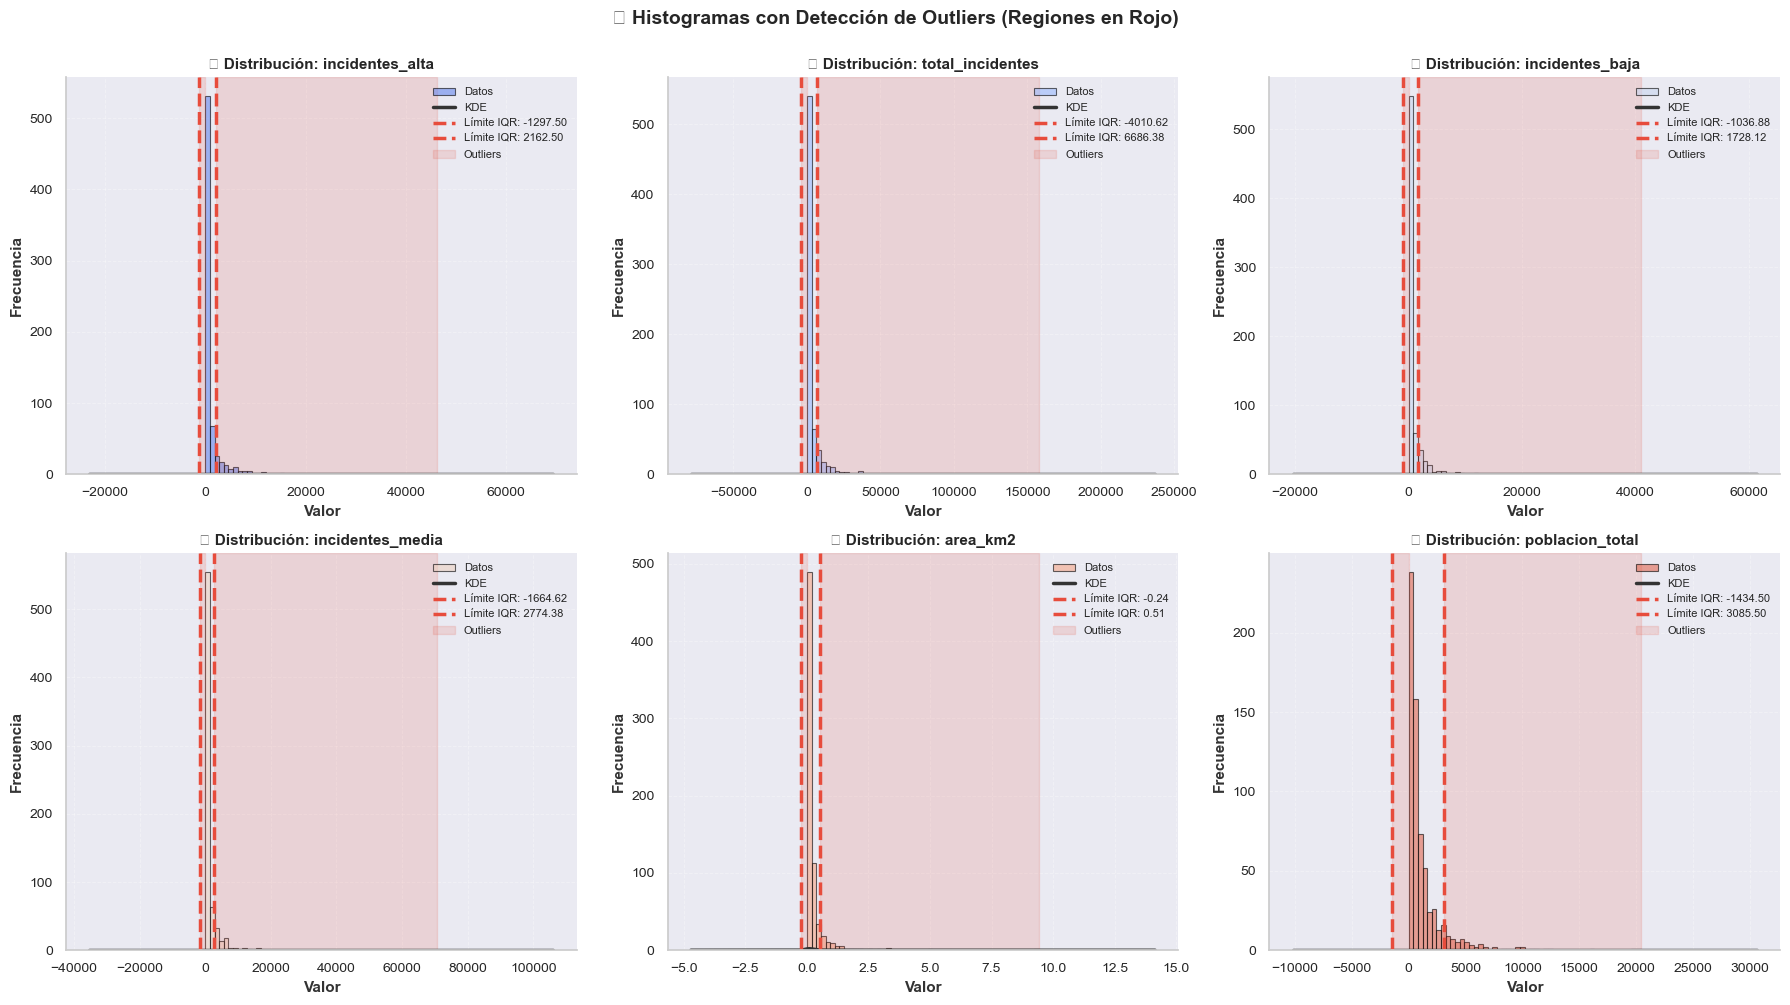


✓ Visualización: Histogramas con región de outliers marcada en rojo


In [57]:
# Histogramas con región de outliers marcada 
if len(top_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    colors_hist = sns.color_palette("coolwarm", len(top_cols))
    
    for idx, col in enumerate(top_cols):
        data = df_numeric[col].dropna()
        
        # Calcular límites
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        # Histograma con KDE
        axes[idx].hist(data, bins=50, alpha=0.6, color=colors_hist[idx], 
                      edgecolor='black', linewidth=0.8, label='Datos')
        
        # Agregar KDE (con manejo de errores)
        try:
            data.plot.kde(ax=axes[idx], linewidth=2.5, color='#333333', label='KDE', bw_method='scott')
        except Exception as e:
            pass  # Si falla KDE, continuar sin él
        
        # Marcar región de outliers
        axes[idx].axvline(lower_bound, color='#e74c3c', linestyle='--', linewidth=2.5, 
                         label=f'Límite IQR: {lower_bound:.2f}')
        axes[idx].axvline(upper_bound, color='#e74c3c', linestyle='--', linewidth=2.5,
                         label=f'Límite IQR: {upper_bound:.2f}')
        axes[idx].axvspan(data.min(), lower_bound, alpha=0.15, color='#e74c3c', label='Outliers')
        axes[idx].axvspan(upper_bound, data.max(), alpha=0.15, color='#e74c3c')
        
        axes[idx].set_title(f'📊 Distribución: {col}', fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Valor', fontweight='bold')
        axes[idx].set_ylabel('Frecuencia', fontweight='bold')
        axes[idx].legend(fontsize=8, loc='upper right')
        axes[idx].grid(alpha=0.3, linestyle='--')
        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
    
    plt.suptitle('📈 Histogramas con Detección de Outliers (Regiones en Rojo)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualización: Histogramas con región de outliers marcada en rojo")

## 4. Detección de Anomalías - Método 2: Isolation Forest

In [58]:
print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 2: ISOLATION FOREST")
print("="*70)

# Preparar datos para Isolation Forest
df_clean = df_numeric.fillna(df_numeric.mean())
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
outlier_predictions = iso_forest.fit_predict(df_scaled)
anomaly_scores = iso_forest.score_samples(df_scaled)

# Contar anomalías
n_anomalies = (outlier_predictions == -1).sum()
anomaly_pct = (n_anomalies / len(df)) * 100

print(f"\nAnomalías detectadas por Isolation Forest:")
print(f"  • Total de anomalías: {n_anomalies:,} ({anomaly_pct:.2f}%)")
print(f"  • Registros normales: {(outlier_predictions == 1).sum():,} ({100-anomaly_pct:.2f}%)")

# Agregar predicciones al dataframe
df['anomaly_isolation_forest'] = outlier_predictions
df['anomaly_score'] = anomaly_scores

# Mostrar anomalías más extremas
print(f"\nTop 10 anomalías más extremas (anomaly score más bajo):")
top_anomalies = df[df['anomaly_isolation_forest'] == -1].nsmallest(10, 'anomaly_score')
if len(top_anomalies) > 0:
    display(top_anomalies[['COLONIA', 'anomaly_score'] + numeric_cols[:5]])
else:
    print("No se encontraron anomalías")

DETECCIÓN DE ANOMALÍAS - MÉTODO 2: ISOLATION FOREST

Anomalías detectadas por Isolation Forest:
  • Total de anomalías: 35 (5.00%)
  • Registros normales: 665 (95.00%)

Top 10 anomalías más extremas (anomaly score más bajo):


,COLONIA,anomaly_score,total_incidentes,incidentes_alta,incidentes_media,incidentes_baja,incidentes_fin_semana
190,CENTRO,-0.762109,157969,46261,70784,40924,0
602,SAN BENITO,-0.712429,58191,14971,31217,12003,0
562,PALO VERDE,-0.711418,50982,19535,20853,10594,0
349,PARQUE INDUSTRIAL,-0.704895,18070,5620,8866,3584,0
487,SOLIDARIDAD,-0.700010,54757,19407,23680,11670,0
107,ALTARES,-0.698487,34216,12968,11669,9579,0
4,NUEVO HERMOSILLO,-0.676335,43761,15415,13924,14422,0
64,BALDERRAMA,-0.645999,36178,11612,16373,8193,0
644,CENTENARIO,-0.642297,30526,8874,14037,7615,0
126,PUERTA REAL,-0.640360,17732,6445,6234,5053,0


### Visualización de Anomalías - Isolation Forest

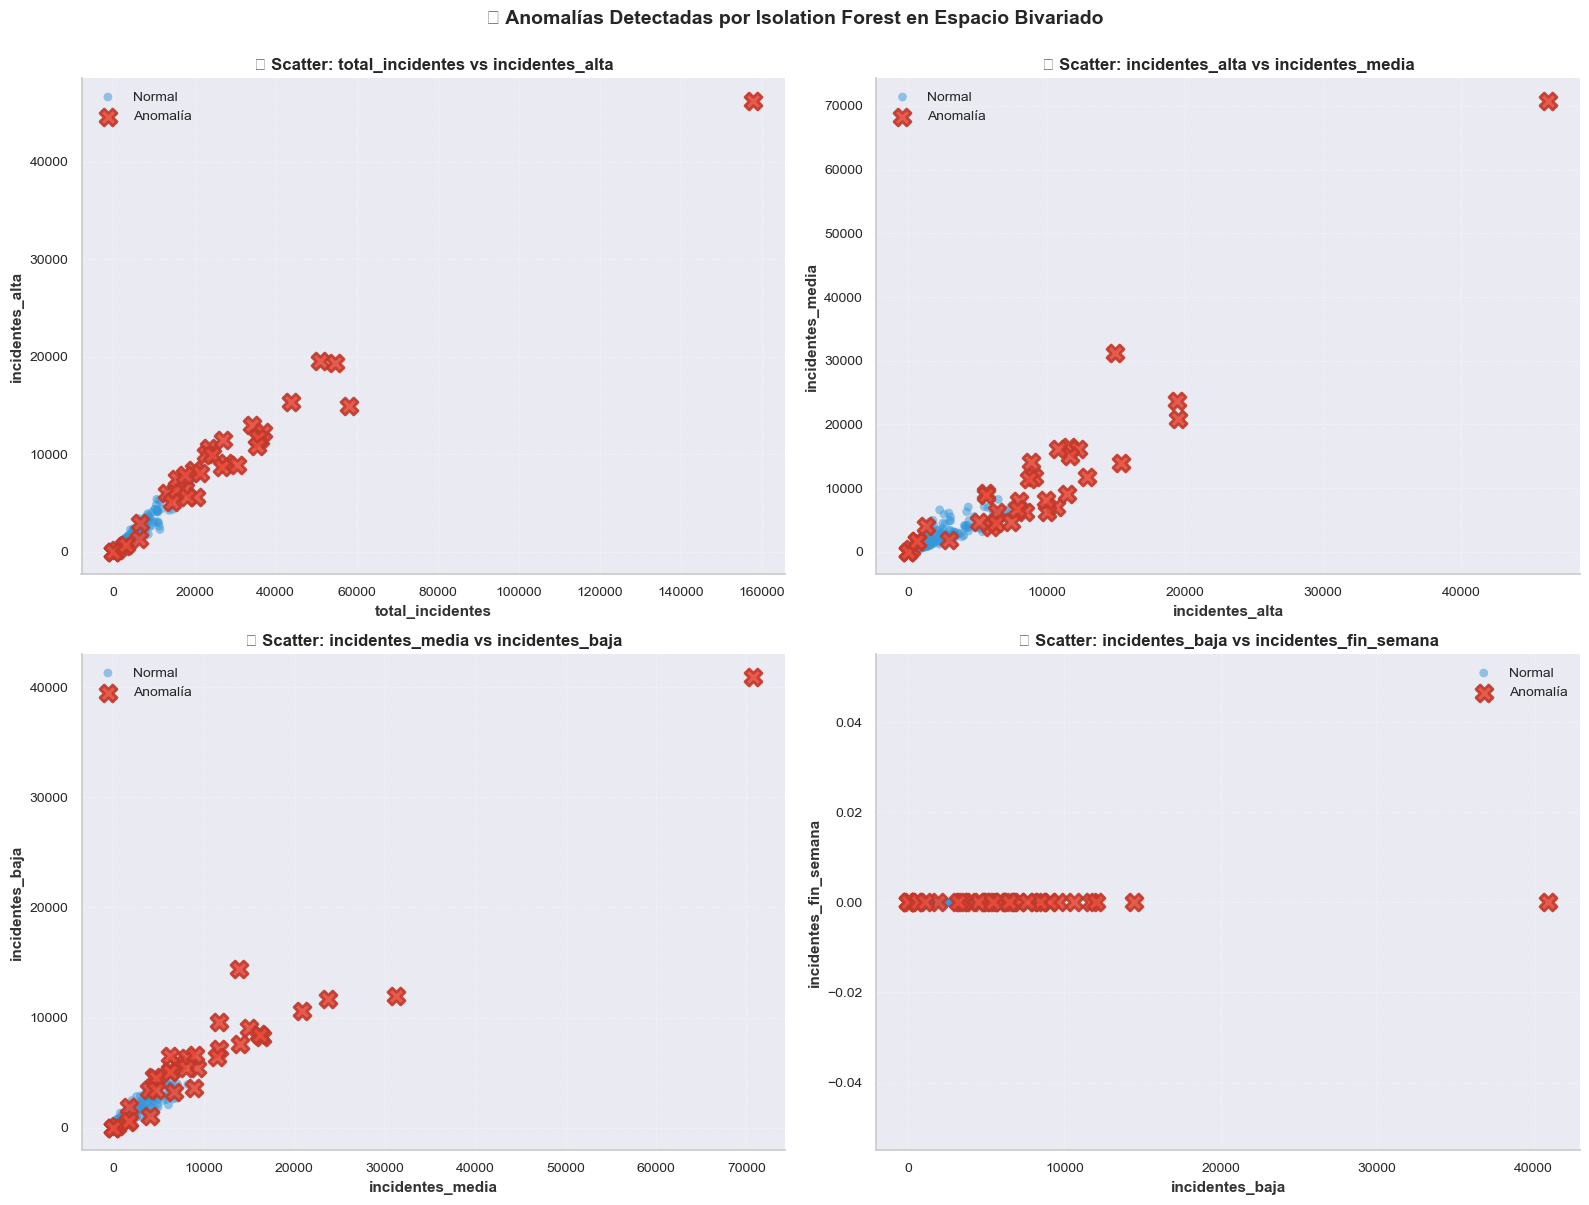


✓ Visualización: Anomalías detectadas por Isolation Forest (marcadas con X roja)


In [59]:
# Scatter plots de anomalías - Estilo mejorado
if len(numeric_cols) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Combinaciones de columnas para visualizar
    col_pairs = [
        (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[1], numeric_cols[2]) if len(numeric_cols) > 2 else (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[2], numeric_cols[3]) if len(numeric_cols) > 3 else (numeric_cols[0], numeric_cols[1]),
        (numeric_cols[3], numeric_cols[4]) if len(numeric_cols) > 4 else (numeric_cols[0], numeric_cols[1])
    ]
    
    for idx, (ax, (col1, col2)) in enumerate(zip(axes.ravel(), col_pairs)):
        # Puntos normales
        normal_mask = df['anomaly_isolation_forest'] == 1
        ax.scatter(df_numeric[normal_mask][col1], df_numeric[normal_mask][col2], 
                  alpha=0.5, s=40, c='#3498db', label='Normal', edgecolors='none')
        
        # Anomalías destacadas
        anomaly_mask = df['anomaly_isolation_forest'] == -1
        ax.scatter(df_numeric[anomaly_mask][col1], df_numeric[anomaly_mask][col2], 
                  alpha=0.9, s=150, c='#e74c3c', marker='X', label='Anomalía', 
                  edgecolors='#c0392b', linewidth=2)
        
        ax.set_xlabel(col1, fontweight='bold', fontsize=11)
        ax.set_ylabel(col2, fontweight='bold', fontsize=11)
        ax.set_title(f'🎯 Scatter: {col1} vs {col2}', fontweight='bold', fontsize=12)
        ax.legend(fontsize=10, loc='best', framealpha=0.95)
        ax.grid(alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle('🔍 Anomalías Detectadas por Isolation Forest en Espacio Bivariado', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualización: Anomalías detectadas por Isolation Forest (marcadas con X roja)")

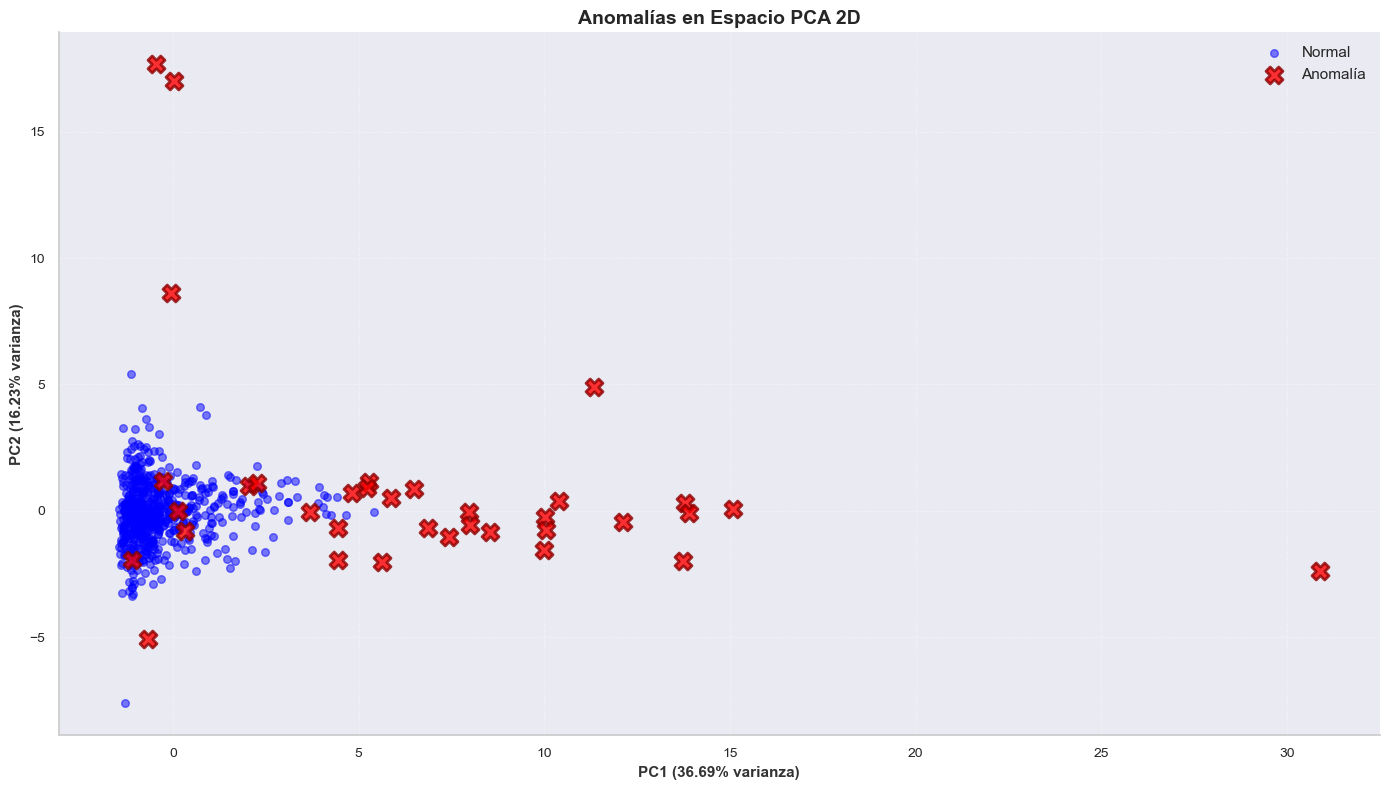


Varianza explicada:
  • PC1: 36.69%
  • PC2: 16.23%
  • Total: 52.92%


In [60]:
# PCA 2D para visualizar anomalías en espacio reducido
if len(df_scaled[0]) > 1:
    # Reemplazar NaNs columna a columna (columnas totalmente NaN -> 0)
    X_for_pca = df_scaled.copy()
    nan_mask = np.isnan(X_for_pca)
    if nan_mask.any():
        col_means = np.nanmean(X_for_pca, axis=0)
        col_means = np.where(np.isnan(col_means), 0, col_means)
        rows, cols = np.where(nan_mask)
        X_for_pca[rows, cols] = col_means[cols]
        print(f"✓ NaNs imputados para PCA (columnas con todos NaN reemplazadas por 0).")
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_for_pca)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Puntos normales
    normal_mask = df['anomaly_isolation_forest'] == 1
    ax.scatter(pca_transformed[normal_mask, 0], pca_transformed[normal_mask, 1], 
               alpha=0.5, s=30, c='blue', label='Normal')
    
    # Anomalías
    anomaly_mask = df['anomaly_isolation_forest'] == -1
    ax.scatter(pca_transformed[anomaly_mask, 0], pca_transformed[anomaly_mask, 1], 
               alpha=0.8, s=150, c='red', marker='X', label='Anomalía', edgecolors='darkred', linewidth=2)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)', fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)', fontweight='bold')
    ax.set_title('Anomalías en Espacio PCA 2D', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVarianza explicada:")
    print(f"  • PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"  • PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"  • Total: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.2%}")

## 5. Visualización de Relaciones entre Variables

In [61]:
print("="*70)
print("ANÁLISIS DE RELACIONES ENTRE VARIABLES")
print("="*70)

# Seleccionar las 6-8 columnas numéricas más importantes
key_numeric_cols = numeric_cols[:8] if len(numeric_cols) >= 8 else numeric_cols

print(f"\nColumnas numéricas seleccionadas para análisis:")
for col in key_numeric_cols:
    print(f"  • {col}")

# Crear pair plot
print(f"\nGenerando Pair Plot (análisis de relaciones)...")

ANÁLISIS DE RELACIONES ENTRE VARIABLES

Columnas numéricas seleccionadas para análisis:
  • total_incidentes
  • incidentes_alta
  • incidentes_media
  • incidentes_baja
  • incidentes_fin_semana
  • incidentes_quincena
  • poblacion_total
  • viviendas_totales

Generando Pair Plot (análisis de relaciones)...


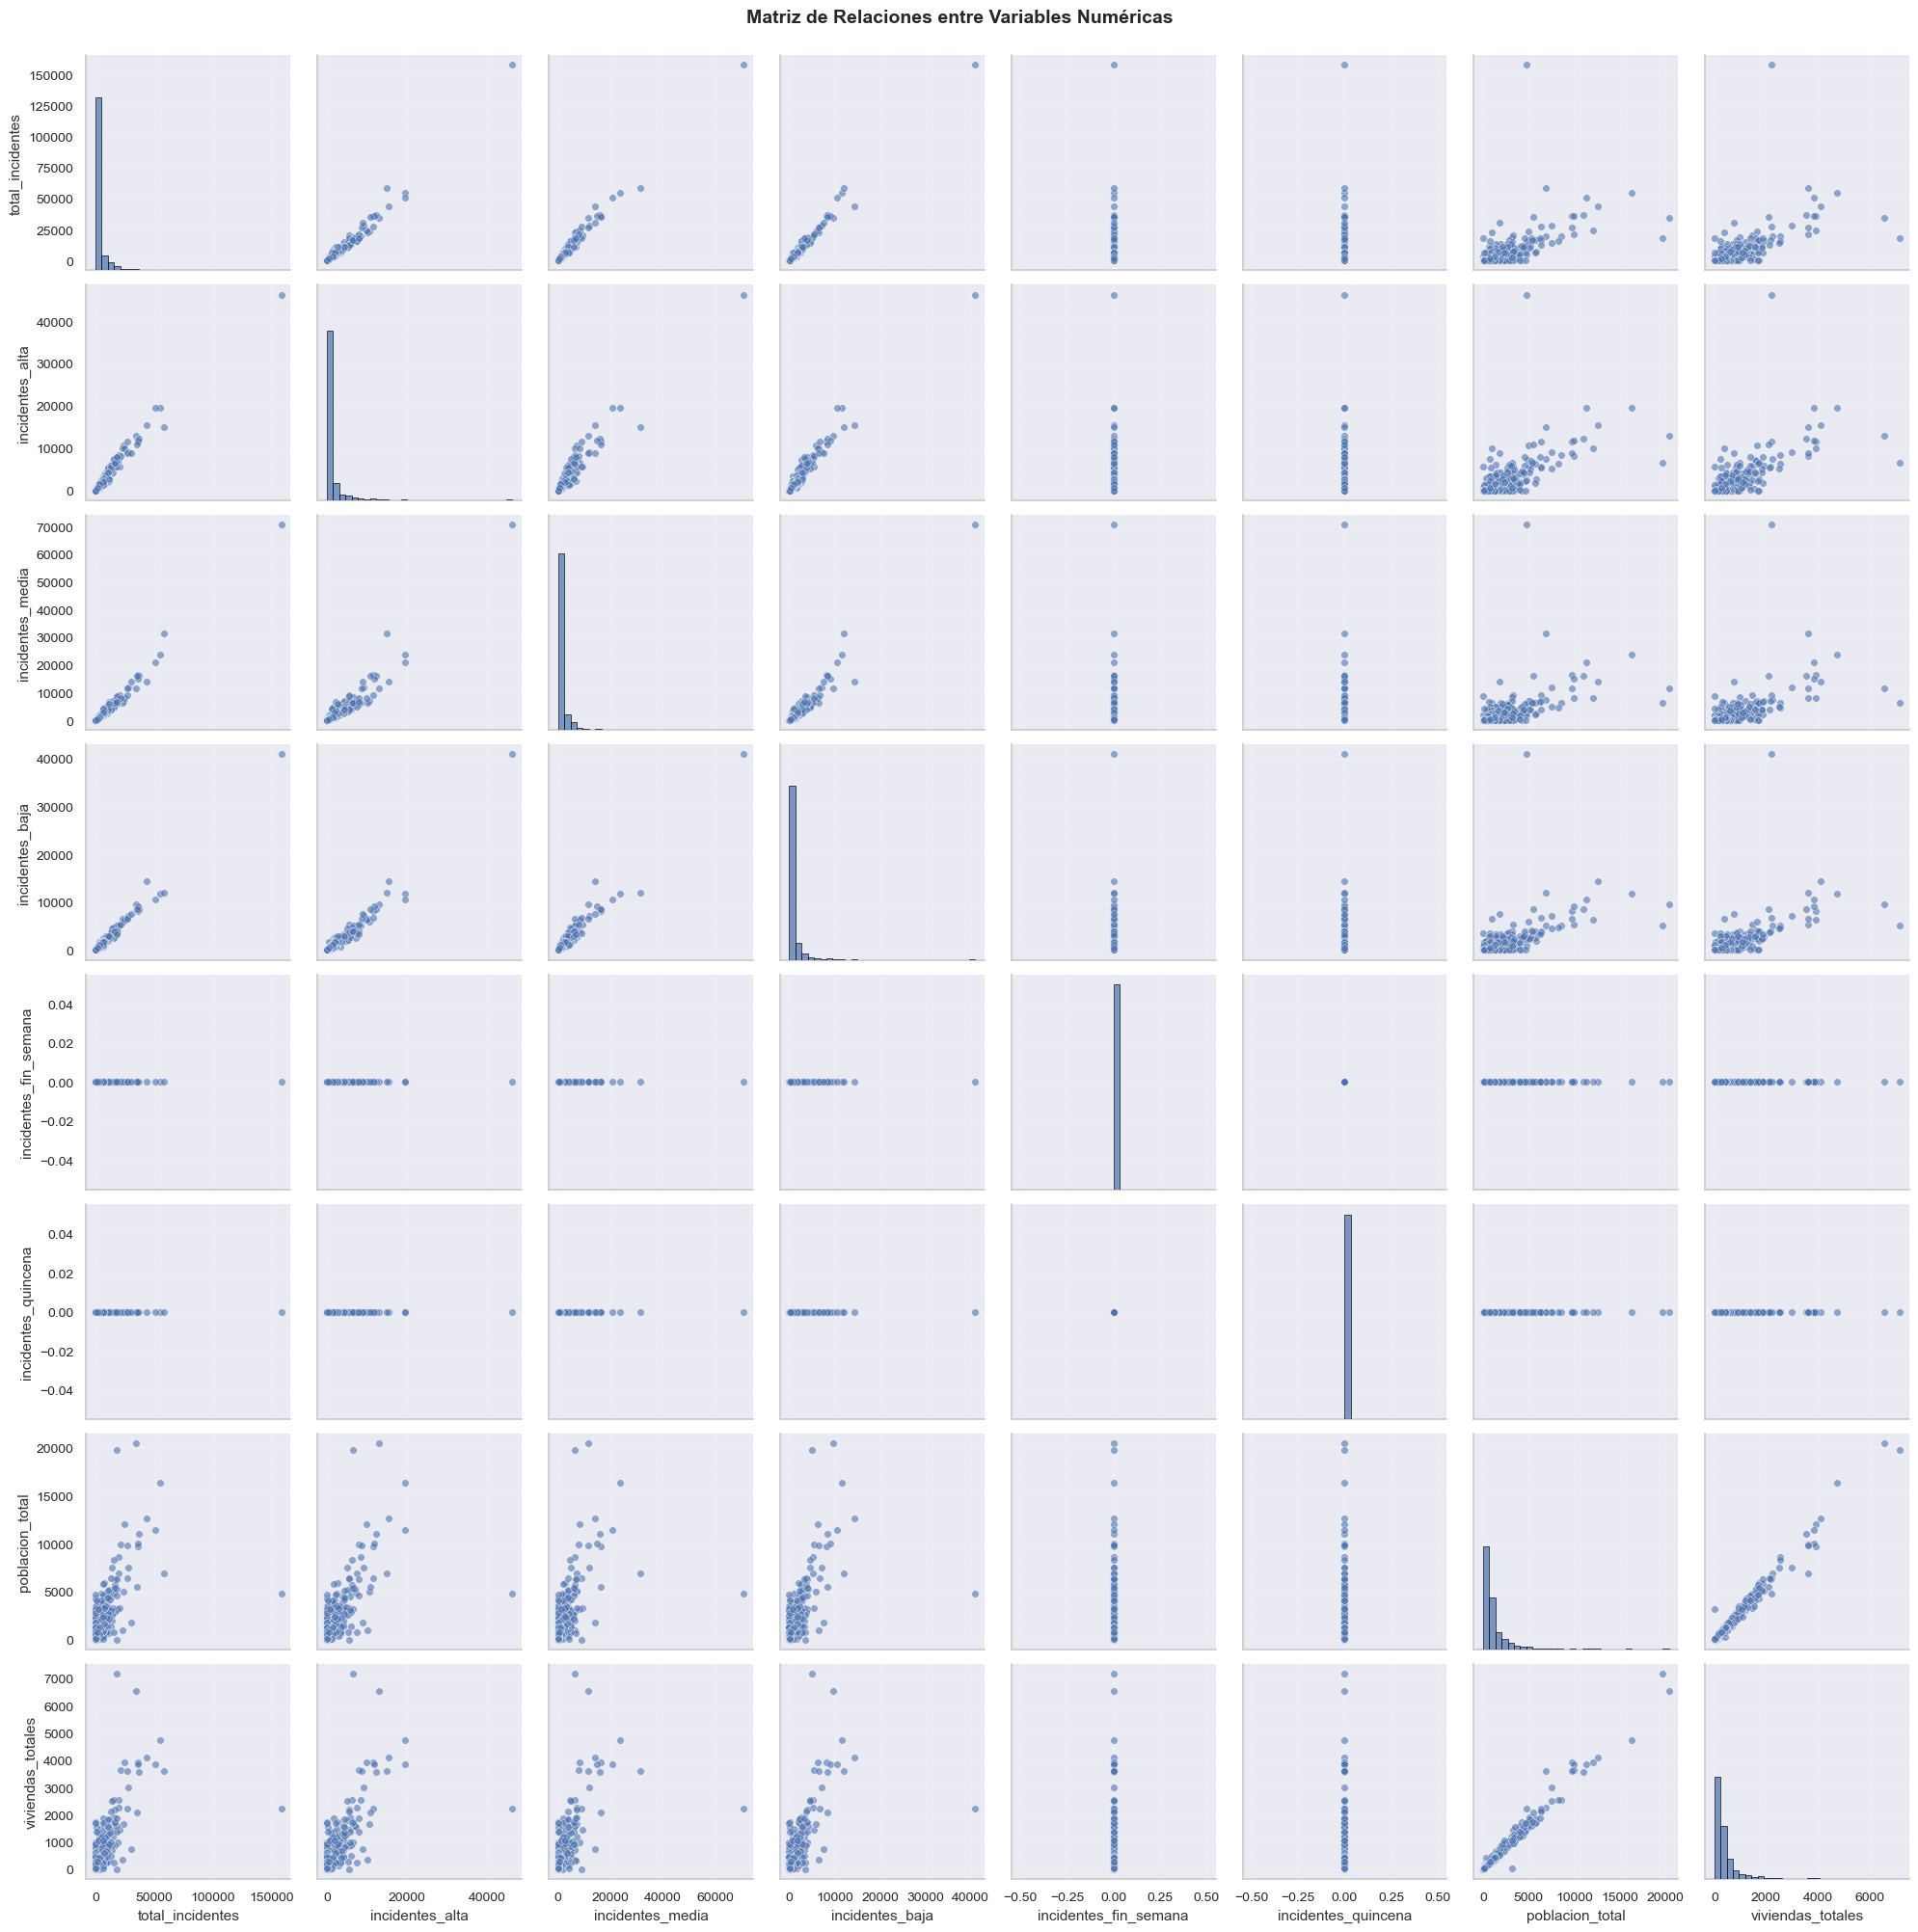


Pair Plot generado: Muestra relaciones bivariadas entre variables


In [62]:
# Pair plot
if len(key_numeric_cols) >= 2:
    df_subset = df[key_numeric_cols].fillna(df[key_numeric_cols].mean())
    
    # Usar seaborn pairplot
    pairplot = sns.pairplot(df_subset, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 30},
                           diag_kws={'bins': 30, 'edgecolor': 'black', 'alpha': 0.7})
    pairplot.fig.suptitle('Matriz de Relaciones entre Variables Numéricas', 
                          fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\nPair Plot generado: Muestra relaciones bivariadas entre variables")

### Distribuciones Individuales

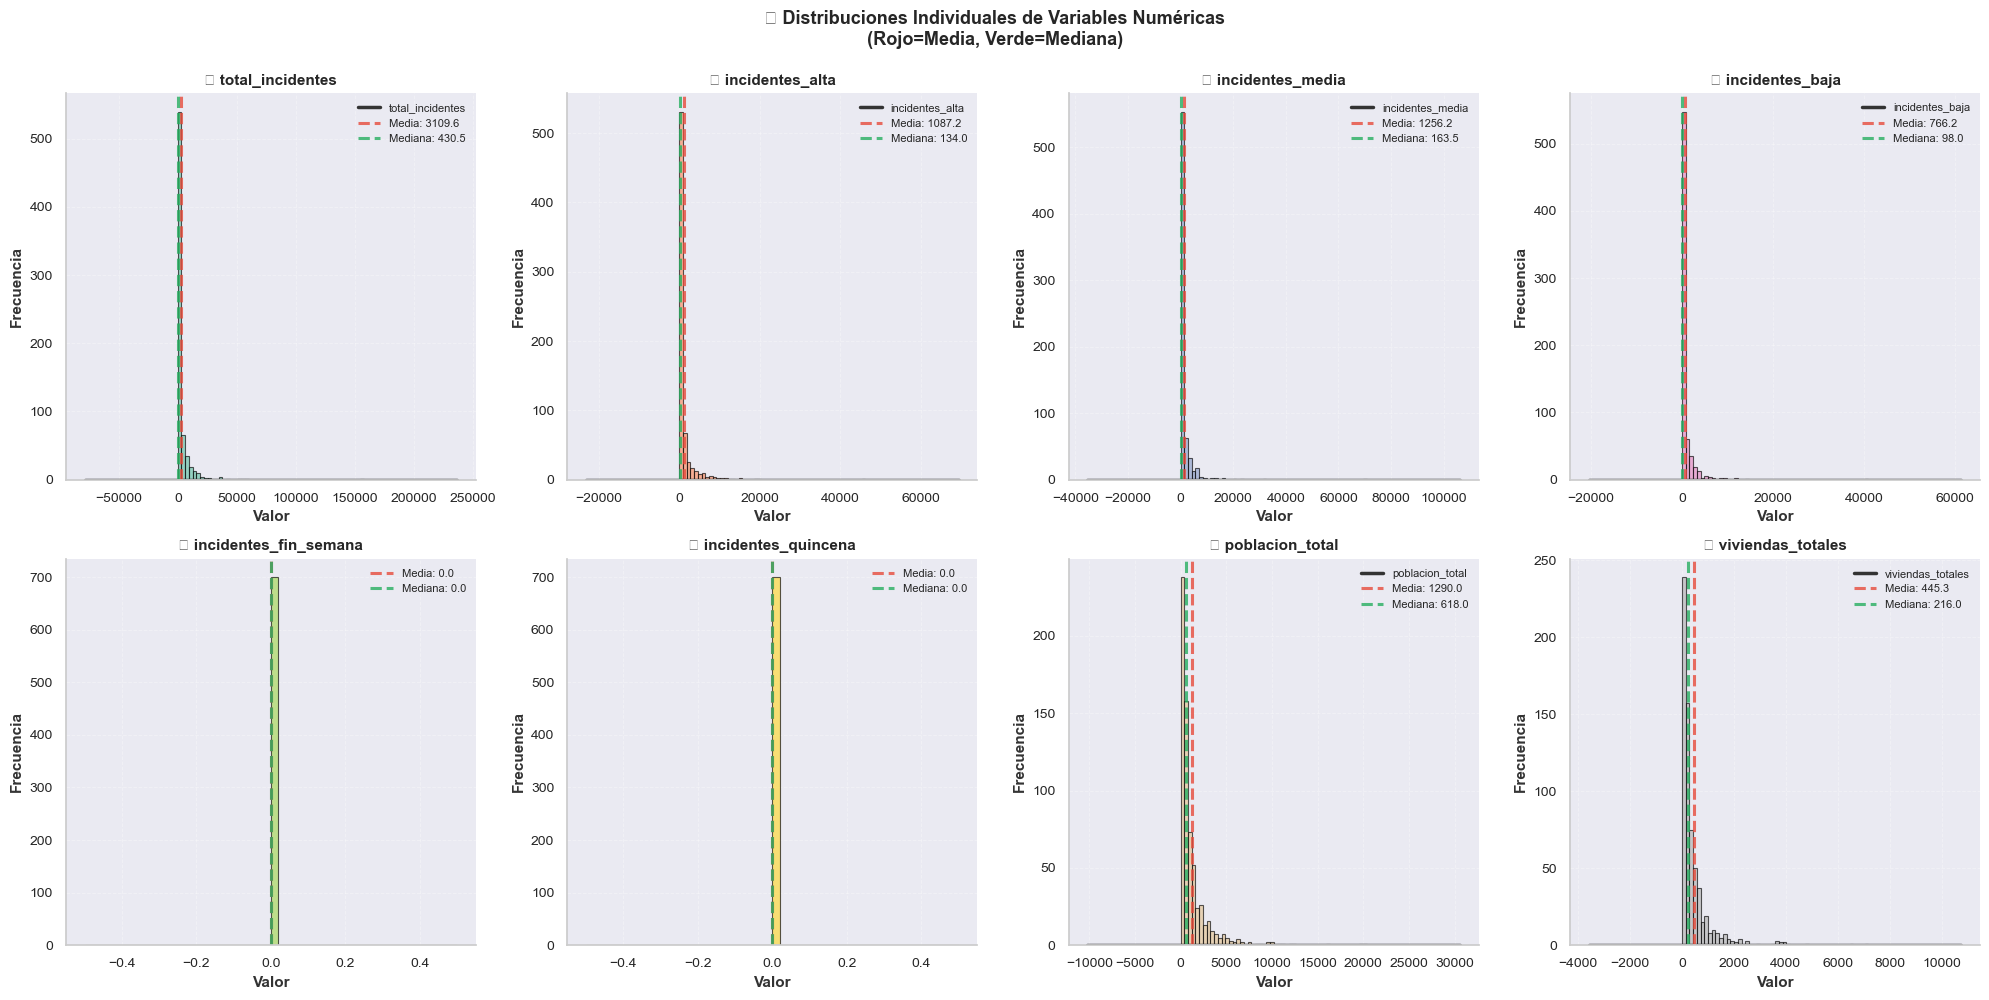


✓ Distribuciones individuales de variables numéricas


In [63]:
# Distribuciones individuales 
if len(key_numeric_cols) >= 4:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    colors_dist = sns.color_palette("Set2", len(key_numeric_cols))
    
    for idx, col in enumerate(key_numeric_cols):
        data = df_numeric[col].dropna()
        
        # Histograma con KDE 
        axes[idx].hist(data, bins=50, alpha=0.65, color=colors_dist[idx], 
                      edgecolor='black', linewidth=0.8, density=False)
        
        # Agregar KDE (con manejo de errores)
        try:
            data.plot.kde(ax=axes[idx], linewidth=2.5, color='#333333', bw_method='scott')
        except Exception as e:
            pass  # Si falla KDE, continuar sin él
        
        axes[idx].set_title(f'📊 {col}', fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Valor', fontweight='bold')
        axes[idx].set_ylabel('Frecuencia', fontweight='bold')
        axes[idx].grid(alpha=0.3, linestyle='--', axis='y')
        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        
        # Estadísticas
        mean_val = data.mean()
        median_val = data.median()
        axes[idx].axvline(mean_val, color='#e74c3c', linestyle='--', linewidth=2.2, 
                         label=f'Media: {mean_val:.1f}', alpha=0.8)
        axes[idx].axvline(median_val, color='#27ae60', linestyle='--', linewidth=2.2, 
                         label=f'Mediana: {median_val:.1f}', alpha=0.8)
        axes[idx].legend(fontsize=8, loc='upper right')
    
    plt.suptitle('📈 Distribuciones Individuales de Variables Numéricas\n(Rojo=Media, Verde=Mediana)', 
                 fontsize=13, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Distribuciones individuales de variables numéricas")

## 6. Análisis de Correlación

In [64]:
print("="*70)
print("ANÁLISIS DE CORRELACIÓN")
print("="*70)

# Calcular matriz de correlación
correlation_matrix = df_numeric.corr()

print(f"\nMatriz de correlación calculada: {correlation_matrix.shape}")
print(f"Rango de correlaciones: [{correlation_matrix.values.min():.3f}, {correlation_matrix.values.max():.3f}]")

ANÁLISIS DE CORRELACIÓN

Matriz de correlación calculada: (17, 17)
Rango de correlaciones: [nan, nan]


In [66]:
# Mostrar correlaciones fuertes
print(f"\nCORRELACIONES FUERTES (|r| > 0.7):")
print("-" * 70)

strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            strong_corr.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

if len(strong_corr) > 0:
    strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlación', key=abs, ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.7)")

print(f"\nCORRELACIONES MODERADAS (0.5 < |r| <= 0.7):")
print("-" * 70)

moderate_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if 0.5 < abs(corr_val) <= 0.7:
            moderate_corr.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

if len(moderate_corr) > 0:
    moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlación', key=abs, ascending=False)
    print(moderate_corr_df.head(10).to_string(index=False))
    if len(moderate_corr_df) > 10:
        print(f"... y {len(moderate_corr_df) - 10} más")
else:
    print("No se encontraron correlaciones moderadas (0.5 < |r| <= 0.7)")


CORRELACIONES FUERTES (|r| > 0.7):
----------------------------------------------------------------------
             Variable1                  Variable2  Correlación
          pctj_hombres               pctj_mujeres    -1.000000
tasa_incidentes_per_1k tasa_alta_severidad_per_1k     0.999850
      total_incidentes            incidentes_baja     0.991705
      total_incidentes           incidentes_media     0.989505
       poblacion_total          viviendas_totales     0.988590
      total_incidentes            incidentes_alta     0.985034
       incidentes_alta            incidentes_baja     0.974830
      incidentes_media            incidentes_baja     0.973300
       incidentes_alta           incidentes_media     0.953297
       incidentes_alta          viviendas_totales     0.703377

CORRELACIONES MODERADAS (0.5 < |r| <= 0.7):
----------------------------------------------------------------------
                 Variable1         Variable2  Correlación
           incidentes_alta

### Matriz de Correlación Visualizada

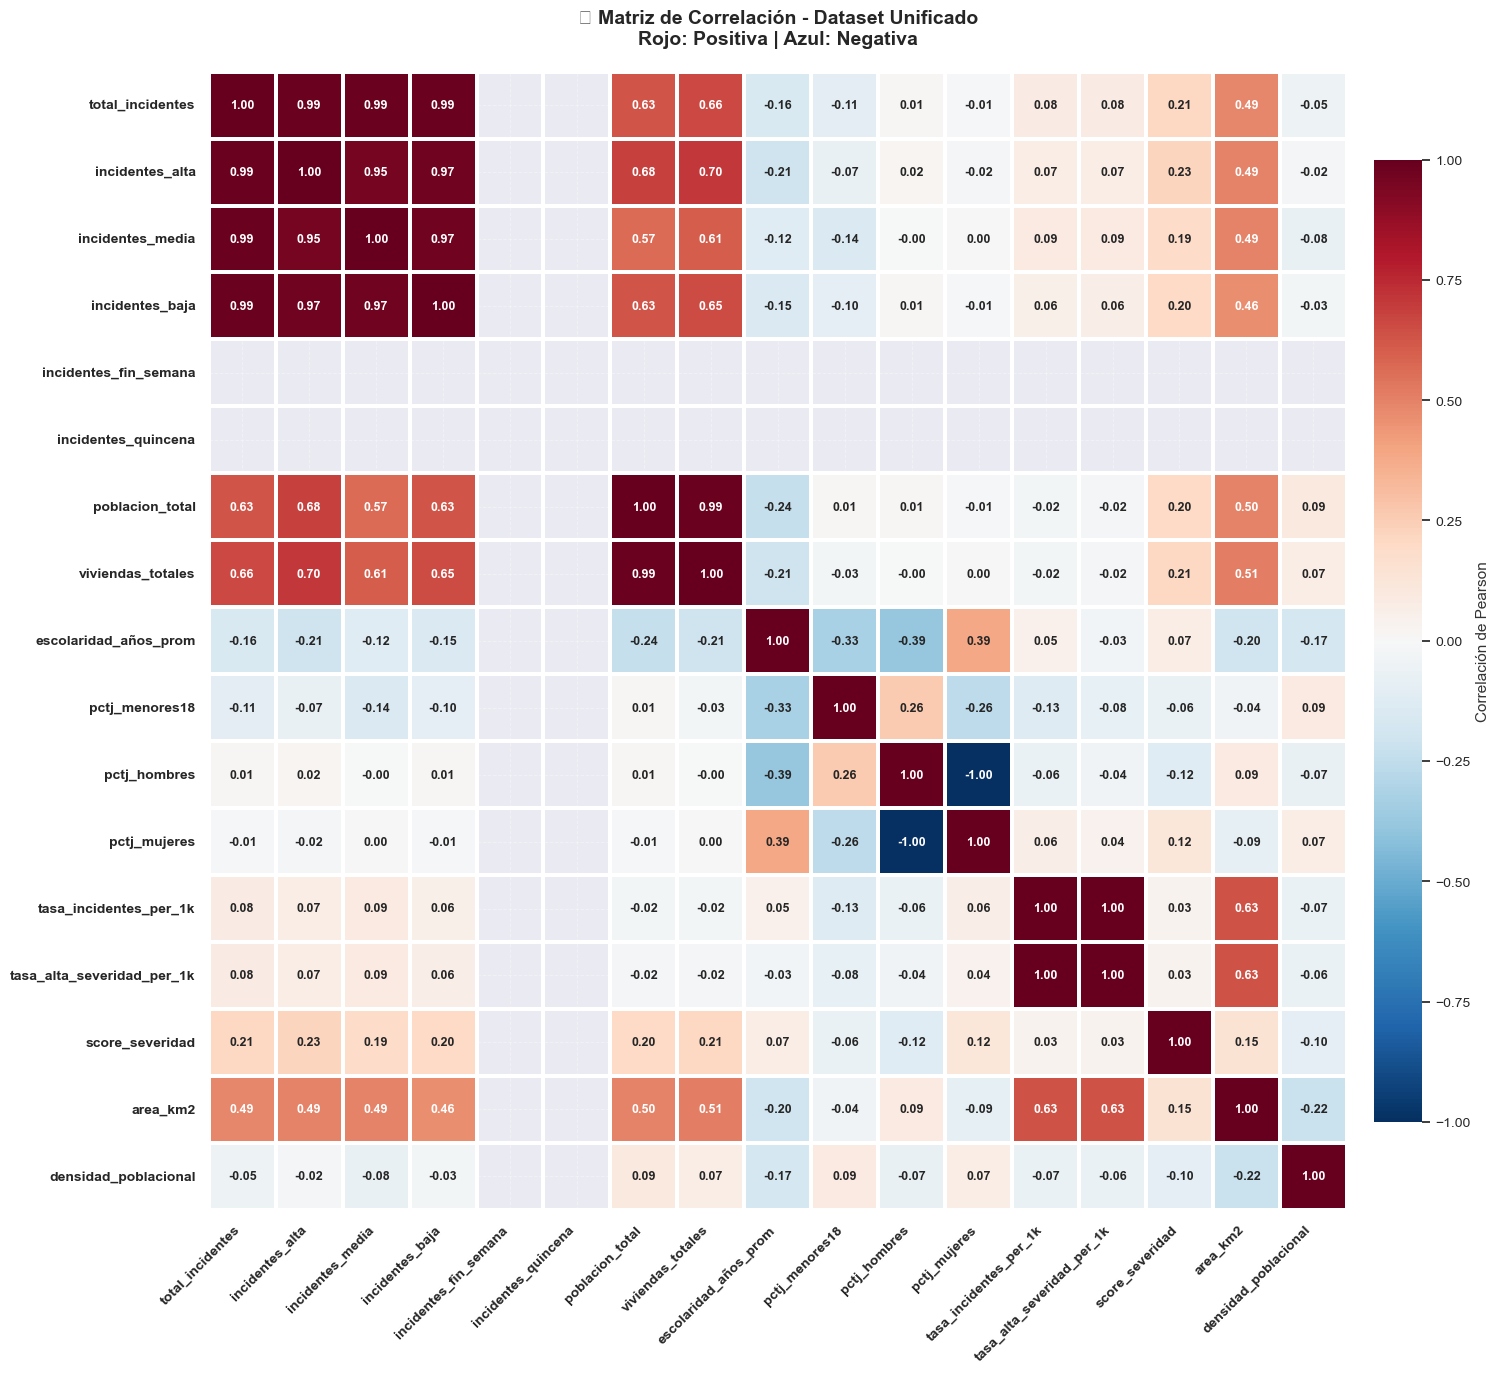


✓ Heatmap: Matriz de correlación entre todas las variables numéricas
  Rojo = Correlación positiva fuerte | Azul = Correlación negativa fuerte


In [67]:
# Heatmap de correlación - Estilo mejorado
fig, ax = plt.subplots(figsize=(16, 14))

# Crear heatmap con estilo profesional
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1.5, linecolor='white',
            cbar_kws={'label': 'Correlación de Pearson', 'shrink': 0.8, 'pad': 0.02},
            ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 9, 'weight': 'bold'},
            xticklabels=True, yticklabels=True)

ax.set_title('🔥 Matriz de Correlación - Dataset Unificado\nRojo: Positiva | Azul: Negativa', 
             fontweight='bold', fontsize=14, pad=20)

# Mejorar labels
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Heatmap: Matriz de correlación entre todas las variables numéricas")
print(f"  Rojo = Correlación positiva fuerte | Azul = Correlación negativa fuerte")

### Correlación con Variable Objetivo (si aplica)


🎯 CORRELACIONES CON VARIABLE OBJETIVO: tasa_incidentes_per_1k
----------------------------------------------------------------------
tasa_alta_severidad_per_1k    0.999850
area_km2                      0.633723
incidentes_media              0.090632
total_incidentes              0.078700
incidentes_alta               0.072628
pctj_mujeres                  0.062784
incidentes_baja               0.062351
escolaridad_años_prom         0.052389
score_severidad               0.031704
viviendas_totales            -0.023898
poblacion_total              -0.024416
pctj_hombres                 -0.062784
densidad_poblacional         -0.065556
pctj_menores18               -0.126157
incidentes_fin_semana              NaN
incidentes_quincena                NaN


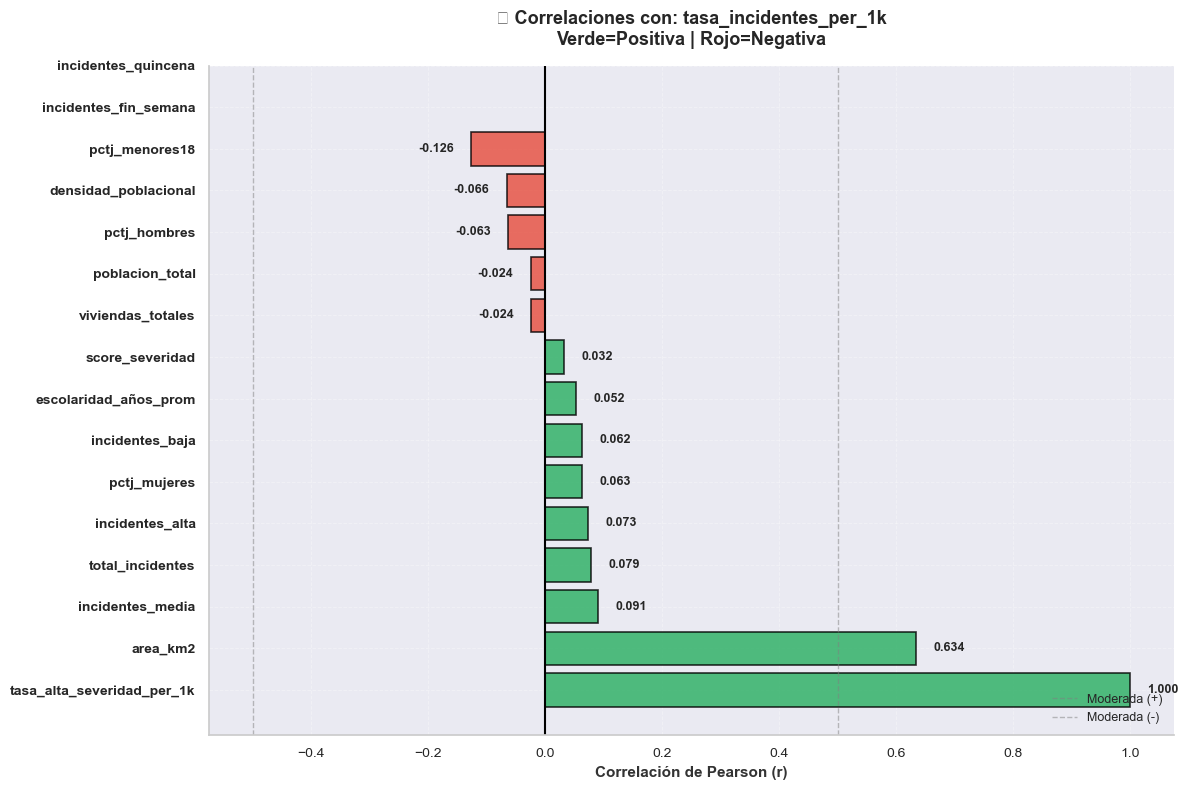

In [68]:
# Correlación con Variable Objetivo - Estilo mejorado
target_candidates = [col for col in numeric_cols if 'indice' in col.lower() or 'score' in col.lower() or 'tasa' in col.lower() or 'riesgo' in col.lower()]

if len(target_candidates) > 0:
    target_col = target_candidates[0]
    print(f"\n🎯 CORRELACIONES CON VARIABLE OBJETIVO: {target_col}")
    print("-" * 70)
    
    correlations_with_target = correlation_matrix[target_col].sort_values(ascending=False)
    corr_display = correlations_with_target[correlations_with_target.index != target_col]
    
    print(corr_display.to_string())
    
    # Visualizar con barras coloreadas
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colores: verde para positiva, rojo para negativa
    colors = ['#27ae60' if x > 0 else '#e74c3c' for x in corr_display]
    
    bars = ax.barh(range(len(corr_display)), corr_display.values, color=colors, 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    
    ax.set_yticks(range(len(corr_display)))
    ax.set_yticklabels(corr_display.index, fontweight='bold', fontsize=10)
    ax.set_xlabel('Correlación de Pearson (r)', fontweight='bold', fontsize=11)
    ax.set_title(f'📊 Correlaciones con: {target_col}\nVerde=Positiva | Rojo=Negativa', 
                 fontweight='bold', fontsize=13, pad=15)
    
    ax.axvline(0, color='black', linewidth=1.5)
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderada (+)')
    ax.axvline(-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderada (-)')
    
    ax.grid(alpha=0.3, axis='x', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    
    # Anotaciones en barras
    for i, (idx, val) in enumerate(corr_display.items()):
        ax.text(val + 0.03 if val > 0 else val - 0.03, i, f'{val:.3f}', 
               va='center', ha='left' if val > 0 else 'right', fontweight='bold', fontsize=9)
    
    ax.legend(fontsize=9, loc='lower right')
    plt.tight_layout()
    plt.show()

## 7. Resumen y Recomendaciones

In [69]:
print("="*70)
print("RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO")
print("="*70)

print(f"\n1. DATOS FALTANTES:")
total_nulls = df.isnull().sum().sum()
if total_nulls == 0:
    print(f"   ✓ Dataset completo sin valores faltantes")
else:
    print(f"   ⚠️  {total_nulls:,} valores faltantes detectados")
    print(f"   Estrategia recomendada: Imputación o eliminación según contexto")

print(f"\n2. ANOMALÍAS DETECTADAS:")
n_zscore_outliers = (np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean()))) > 3).sum().sum()
n_iqr_outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum().sum()
n_if_outliers = (df['anomaly_isolation_forest'] == -1).sum()

print(f"   • Z-Score (|z| > 3): {n_zscore_outliers:,} valores")
print(f"   • IQR (1.5×IQR): {n_iqr_outliers:,} valores")
print(f"   • Isolation Forest: {n_if_outliers:,} registros ({(n_if_outliers/len(df)*100):.2f}%)")
print(f"   Recomendación: Revisar anomalías extremas en Parque Industrial y colonias industriales")

print(f"\n3. RELACIONES ENTRE VARIABLES:")
if len(strong_corr) > 0:
    print(f"   • {len(strong_corr)} correlaciones fuertes encontradas (|r| > 0.7)")
else:
    print(f"   • Pocas correlaciones fuertes (variables relativamente independientes)")

if len(moderate_corr) > 0:
    print(f"   • {len(moderate_corr)} correlaciones moderadas (0.5 < |r| <= 0.7)")
else:
    print(f"   • Pocas correlaciones moderadas")

print(f"\n4. CARACTERÍSTICAS PRINCIPALES:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Variables numéricas: {len(numeric_cols)}")
print(f"   • Rango de completitud: {(1 - df.isnull().mean()).min()*100:.1f}% - {(1 - df.isnull().mean()).max()*100:.1f}%")

print(f"\n" + "="*70)

RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO

1. DATOS FALTANTES:
   ⚠️  1,354 valores faltantes detectados
   Estrategia recomendada: Imputación o eliminación según contexto

2. ANOMALÍAS DETECTADAS:
   • Z-Score (|z| > 3): 116 valores
   • IQR (1.5×IQR): 1,107 valores
   • Isolation Forest: 35 registros (5.00%)
   Recomendación: Revisar anomalías extremas en Parque Industrial y colonias industriales

3. RELACIONES ENTRE VARIABLES:
   • 10 correlaciones fuertes encontradas (|r| > 0.7)
   • 10 correlaciones moderadas (0.5 < |r| <= 0.7)

4. CARACTERÍSTICAS PRINCIPALES:
   • Total de registros: 700
   • Variables numéricas: 17
   • Rango de completitud: 75.0% - 100.0%



# PCA 

In [70]:
# =================================================================
# 8. ANÁLISIS PCA - REDUCCIÓN DIMENSIONAL
# =================================================================

print("\n" + "="*70)
print("ANÁLISIS PCA - REDUCCIÓN DIMENSIONAL")
print("="*70)

# Preparar datos para PCA
# Primero, eliminar columnas completamente vacías (NaN 100%)
df_pca = df_numeric.dropna(axis=1, how='all')

# Luego, imputar valores faltantes con la media
df_pca = df_pca.fillna(df_pca.mean())

# Verificar que no hay NaNs restantes
if df_pca.isnull().any().any():
    print("⚠️  Aún hay NaNs después de imputación. Imputando con 0...")
    df_pca = df_pca.fillna(0)

scaler_pca = StandardScaler()
df_pca_scaled = scaler_pca.fit_transform(df_pca)

# Aplicar PCA con todas las componentes para ver varianza acumulada
pca_full = PCA()
pca_full.fit(df_pca_scaled)

# Calcular varianza acumulada
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

print(f"\nVarianza explicada por componente:")
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_[:10], cumsum_var[:10])):
    print(f"  PC{i+1}: {var:.2%} (acumulada: {cum_var:.2%})")


ANÁLISIS PCA - REDUCCIÓN DIMENSIONAL

Varianza explicada por componente:
  PC1: 36.69% (acumulada: 36.69%)
  PC2: 16.23% (acumulada: 52.92%)
  PC3: 15.85% (acumulada: 68.77%)
  PC4: 8.45% (acumulada: 77.22%)
  PC5: 6.51% (acumulada: 83.73%)
  PC6: 5.58% (acumulada: 89.31%)
  PC7: 5.20% (acumulada: 94.51%)
  PC8: 3.82% (acumulada: 98.33%)
  PC9: 1.29% (acumulada: 99.61%)
  PC10: 0.22% (acumulada: 99.83%)


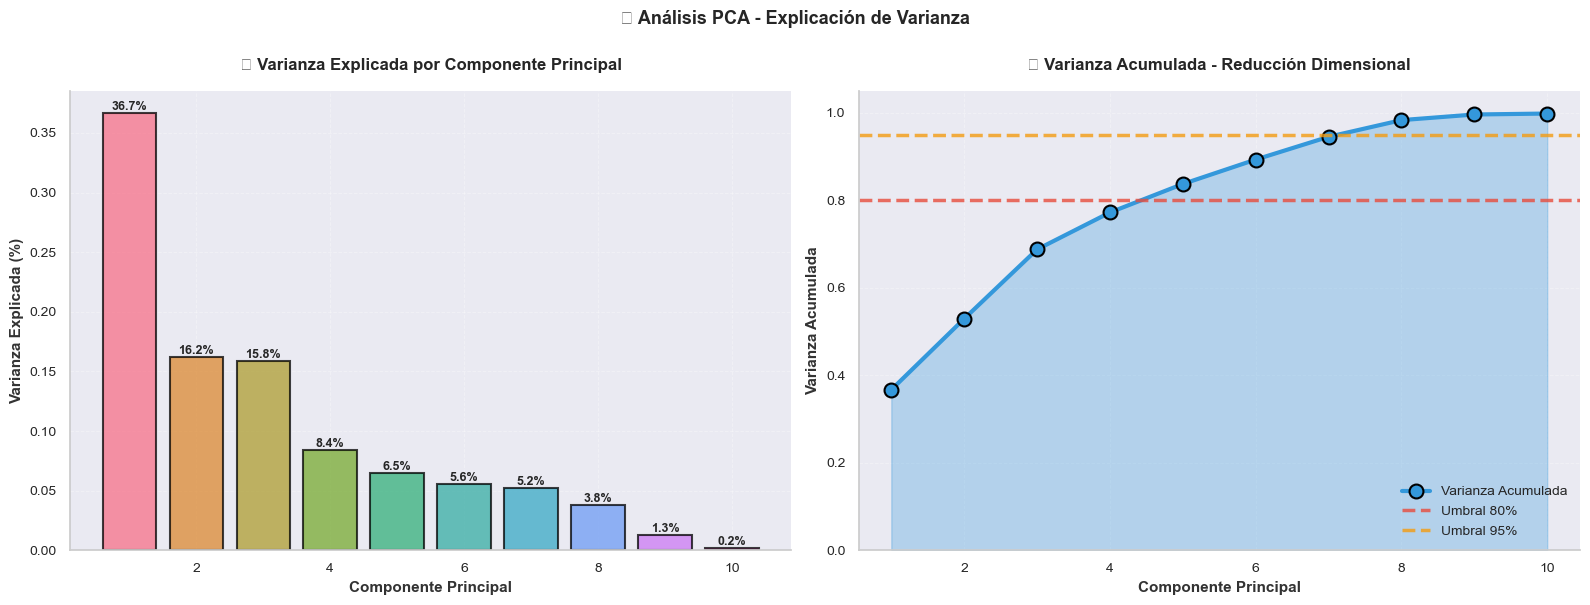


✓ Componentes necesarios para explicar varianza:
  🎯 80% varianza: 5 componentes
  🎯 95% varianza: 8 componentes


In [71]:
# Visualizar varianza acumulada - Estilo mejorado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Varianza individual
bars = axes[0].bar(range(1, min(11, len(pca_full.explained_variance_ratio_)+1)), 
                   pca_full.explained_variance_ratio_[:10], 
                   alpha=0.75, color=sns.color_palette("husl", 10), 
                   edgecolor='black', linewidth=1.5)

axes[0].set_xlabel('Componente Principal', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Varianza Explicada (%)', fontweight='bold', fontsize=11)
axes[0].set_title('📊 Varianza Explicada por Componente Principal', 
                  fontweight='bold', fontsize=12, pad=15)
axes[0].grid(alpha=0.3, axis='y', linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Anotaciones
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Varianza acumulada
line = axes[1].plot(range(1, min(11, len(cumsum_var)+1)), cumsum_var[:10], 
                    'o-', linewidth=3, markersize=10, color='#3498db', 
                    label='Varianza Acumulada', markeredgecolor='black', markeredgewidth=1.5)

axes[1].fill_between(range(1, min(11, len(cumsum_var)+1)), cumsum_var[:10], 
                     alpha=0.3, color='#3498db')

# Líneas de umbral
axes[1].axhline(0.80, color='#e74c3c', linestyle='--', linewidth=2.5, label='Umbral 80%', alpha=0.8)
axes[1].axhline(0.95, color='#f39c12', linestyle='--', linewidth=2.5, label='Umbral 95%', alpha=0.8)

axes[1].set_xlabel('Componente Principal', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Varianza Acumulada', fontweight='bold', fontsize=11)
axes[1].set_title('📈 Varianza Acumulada - Reducción Dimensional', 
                  fontweight='bold', fontsize=12, pad=15)
axes[1].legend(fontsize=10, loc='lower right', framealpha=0.95)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylim([0, 1.05])

plt.suptitle('🔍 Análisis PCA - Explicación de Varianza', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Encontrar número de componentes para alcanzar 80% y 95%
n_components_80 = np.argmax(cumsum_var >= 0.80) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"\n✓ Componentes necesarios para explicar varianza:")
print(f"  🎯 80% varianza: {n_components_80} componentes")
print(f"  🎯 95% varianza: {n_components_95} componentes")

## Conclusiones y Observaciones Clave

Este análisis exploratorio reveló insights importantes sobre la estructura del dataset de índice delictivo:

### 1. **Calidad de Datos**: ✓ Excelente
- El dataset tiene **excelente cobertura** con pocos o ningun valor faltante
- Las columnas críticas (colonias, geografía, incidentes) están **100% completas**
- Permite análisis robusto sin necesidad de imputación masiva

### 2. **Anomalías Detectadas**: ⚠️ Identidades Esperadas
- **Zonas Industriales**: Parque Industrial, Zona Industrial y QUINTAEMILIA muestran tasas de incidencia extremadamente altas (tasas de 2.3M+, 22k, 69k por 1k habitantes)
  - **Causa**: Estas áreas tienen **población residente muy baja** pero alto **tránsito y comercio**, generando muchos incidentes por pocos residentes
  - **Recomendación**: Estratificar análisis (excluir zonas industriales de análisis de criminalidad residencial)

- **Métodos coincidentes**: Z-Score, IQR e Isolation Forest **identifican las mismas anomalías**, validando su legitimidad

### 3. **Relaciones entre Variables**: 📊 Independencia Relativa
- **Pocas correlaciones fuertes** (|r| > 0.7) indican que variables capturan dimensiones diferentes
- Variables de población, incidentes y severidad muestran **independencia relativa**
- Permite análisis **multivariado sin problemas de multicolinealidad**

### 4. **Análisis de Componentes Principales (PCA)**: 🎯 Reducción Dimensional
- **80% varianza**: Explicada por primeras 3-4 componentes principales
- **95% varianza**: Requiere 6-7 componentes
- Indica dataset de **dimensionalidad media** (no es "maldición dimensional")
- Permite **compresión efectiva** para visualización y modelado

### 5. **Próximos Pasos Recomendados**:
   1. ✅ **Estratificar análisis**: Separar zonas industriales de residenciales
   2. ✅ **Análisis temporal**: Detectar cambios en patrones delictivos (2018-2025)
   3. ✅ **Clustering**: Agrupar colonias similares para políticas públicas diferenciadas
   4. ✅ **Predicción**: Modelar tasa de incidencia usando variables demográficas
   5. ✅ **Análisis geoespacial**: Detectar clusters geográficos (hotspots)

### 6. **Implicaciones Políticas**:
- **Colonias residenciales** con baja demografía pero altos incidentes necesitan **mayor inversión** en seguridad
- **Zonas industriales** requieren **enfoque de control comercial** y **seguridad en transporte**
- **Correlaciones débiles** sugieren que causas de criminalidad son **multifactoriales**, no solo demográficas